Update as needed and hit run all

In [ ]:
### Run the line below if PSG_POWER_PYTHON is not installed
!pip install --upgrade somnopy

In [2]:
# ----------------- Load packages ------------------- #
import os
import contextlib
import io
import numpy as np
import pandas as pd
import mne
from scipy.io import loadmat
import warnings
import matplotlib.pyplot as plt
import time


from somnopy import *
from somnopy.somno import get_sosp, get_sosp_for_folder
from somnopy.event_detection import SO_detection, SP_detection, detect_swa
from somnopy.metrics import pac,event_lock
from somnopy.utils import set_up_raw


In [3]:
###The following are REQUIRED PARAMETERS:

processed_eeg_folder = 'data/Scored files to be analyzed/'  # path to folder with the eeg files
scoring_file = 'data/Scored files to be analyzed/'  # path to folder with the stage scored files


# ###The following are OPTIONAL PARAMETERS, the default value is what you see, update as necessary:
# interest_stage = ('N2', 'SWS') #sleep stages interested in evaluating
# sp_method = 'Hahn2020' #Method used for spindle detection. See available methods below
# so_method = 'Staresina' #Method used for slow oscillation detection. See available methods below
coupling = True #If set to true, additional metrics such as PAC, or spindle to slow oscillation coupling percentage will be calulated and plotted
# scoring_dur = 30 # (in seconds) the duration of each epoch used for sleep scoring
# rereference = False # If reference channels are not contralateral mostoids or you are unsure, otherwise set to: rereference = ['M1', 'M2'], also optional to set 'average' to use the average of all channels as reference
chan_limit = ['F3', 'C3', 'F4', 'C4'] # Use None to process all channels, or use ['Fz', 'Cz', 'F3', 'C3', ...] to process selected channels only.
# channels_to_drop = ('E1', 'E2', 'ChinC', 'ChinL', 'ChinR') #by default, will drop non-eeg channels. Add any channels that you would want to drop completely
# montage_temp = "standard_1005" # Use standard_1005 for mid and high-density caps, standard_1020 for low-density caps, or specify another montage. See other available montages below
# baseline = True # Baseline correction before the event detection
# verbose = True # Additional diagnostic plotting/ printing if set to true
# #The following are customisable Slow Oscillatoin detection metrics, that have different default depending on method used
# filter_freq = None
# duration = None
# filter_type = 'fir'
# #The following are customisable Spindle detection metrics, that have different default depending on method used
# l_freq = None
# h_freq = None
# dur_lower = None
# dur_upper = None


In [4]:
### Available Spindle detection methods:

'''
1) hahn2020 (default)
       - 12-16 Hz bandpass filter, Hilbert transform to obtain amplitude envelope,
         thresholded at a given percentile (default 75th),
         with a duration criterion of 0.5 to 3 seconds.

    2) martin2013
       - 11-15 Hz bandpass filter (linear phase FIR, forward and reverse for 0-phase distortion).
       - Compute RMS of the filtered signal with a 0.25 s time window.
       - Threshold at its 95th percentile (published criteria: Schabus et al., 2007).
       - A spindle is identified if at least two consecutive RMS time points
         exceed the threshold, and total duration >= 0.5 s.

    3) wamsley2012
       - Discrete sleep spindle events detected using a wavelet-based algorithm
         with an 8-parameter complex Morlet wavelet, ~10-16 Hz range.
       - Spindles are identified at each channel by a thresholding algorithm
         applied to the wavelet scale corresponding to 10-16 Hz.
       - The rectified moving average of this wavelet signal is calculated
         with a 100 ms sliding window.
       - Threshold = 4.5 times the mean signal amplitude across artifact-free epochs.
       - Duration >= 0.4 s to count as a spindle.

    4) Wendt2012
       - The raw data are bandpass filtered between 11-16 Hz.
       - The signal is then rectified.
       - Two separate lowpass filters are applied to create two envelopes
         (one ~2.25 Hz passband with offset 3 μV, the other ~1 Hz passband with offset 8 μV).
       - A time-varying threshold is formed by each envelope + offset.
       - Any rectified signal crossing either threshold boundary within 0.5-3 s
         is considered a spindle candidate. A final decision fusion is applied

    5) Ferrarelli2007
       - 12-15 Hz bandpass filter (–3 dB at 12 and 15 Hz).
       - The amplitude of the rectified filtered signal is used as the time series.
       - If the signal's amplitude exceeds an upper threshold (8 × channel average amplitude),
         it is considered a spindle candidate. Peak amplitude is the local maximum above
         that threshold. The start and end are the preceding/following points
         where amplitude drops below a lower threshold (2 × channel average amplitude).
       - Duration >= 0.5 s is typically required (AASM-based).
'''

"\n1) hahn2020 (default)\n       - 12-16 Hz bandpass filter, Hilbert transform to obtain amplitude envelope,\n         thresholded at a given percentile (default 75th),\n         with a duration criterion of 0.5 to 3 seconds.\n\n    2) martin2013\n       - 11-15 Hz bandpass filter (linear phase FIR, forward and reverse for 0-phase distortion).\n       - Compute RMS of the filtered signal with a 0.25 s time window.\n       - Threshold at its 95th percentile (published criteria: Schabus et al., 2007).\n       - A spindle is identified if at least two consecutive RMS time points\n         exceed the threshold, and total duration >= 0.5 s.\n\n    3) wamsley2012\n       - Discrete sleep spindle events detected using a wavelet-based algorithm\n         with an 8-parameter complex Morlet wavelet, ~10-16 Hz range.\n       - Spindles are identified at each channel by a thresholding algorithm\n         applied to the wavelet scale corresponding to 10-16 Hz.\n       - The rectified moving average

In [5]:
### Available Slow Oscillation detection methods:

'''
    'Staresina': {'filter_freq': (0.16, 1.25), 'duration': (0.8, 2)},
    'Ng': {'filter_freq': (0.16, 1.25), 'duration': (0.8, 2)},
    'Massimini': {'filter_freq': (0.1, 4), 'duration': (0.8, 2)},
    'Dimulescu': {'filter_freq': (0.1, 4), 'duration': (0.8, 2)},
    'Molle': {'filter_freq': (0.1, 2), 'duration': (0.9, 2)},
    'Ngo': {'filter_freq': (None, 3.5), 'duration': (0.9, 2)}
'''

"\n    'Staresina': {'filter_freq': (0.16, 1.25), 'duration': (0.8, 2)},\n    'Ng': {'filter_freq': (0.16, 1.25), 'duration': (0.8, 2)},\n    'Massimini': {'filter_freq': (0.1, 4), 'duration': (0.8, 2)},\n    'Dimulescu': {'filter_freq': (0.1, 4), 'duration': (0.8, 2)},\n    'Molle': {'filter_freq': (0.1, 2), 'duration': (0.9, 2)},\n    'Ngo': {'filter_freq': (None, 3.5), 'duration': (0.9, 2)}\n"

In [6]:
### Available Montages

# standard_1005: Electrodes are named and positioned according to the international 10-05 system (343+3 locations)
# standard_1020: Electrodes are named and positioned according to the international 10-20 system (94+3 locations)
# standard_alphabetic: Electrodes are named with LETTER-NUMBER combinations (A1, B2, F4, …) (65+3 locations)
# standard_postfixed: Electrodes are named according to the international 10-20 system using postfixes for intermediate positions (100+3 locations)
# standard_prefixed: Electrodes are named according to the international 10-20 system using prefixes for intermediate positions (74+3 locations)
# standard_primed: Electrodes are named according to the international 10-20 system using prime marks (' and '') for intermediate positions (100+3 locations)
# biosemi16: BioSemi cap with 16 electrodes (16+3 locations)
# biosemi32: BioSemi cap with 32 electrodes (32+3 locations)
# biosemi64: BioSemi cap with 64 electrodes (64+3 locations)
# biosemi128: BioSemi cap with 128 electrodes (128+3 locations)
# biosemi160: BioSemi cap with 160 electrodes (160+3 locations)
# biosemi256: BioSemi cap with 256 electrodes (256+3 locations)
# easycap-M1: EasyCap with 10-05 electrode names (74 locations)
# easycap-M10: EasyCap with numbered electrodes (61 locations)
# easycap-M43: EasyCap with numbered electrodes (64 locations)
# EGI_256: Geodesic Sensor Net (256 locations)
# GSN-HydroCel-32: HydroCel Geodesic Sensor Net and Cz (33+3 locations)
# GSN-HydroCel-64_1.0: HydroCel Geodesic Sensor Net (64+3 locations)
# GSN-HydroCel-65_1.0: HydroCel Geodesic Sensor Net and Cz (65+3 locations)
# GSN-HydroCel-128: HydroCel Geodesic Sensor Net (128+3 locations)
# GSN-HydroCel-129: HydroCel Geodesic Sensor Net and Cz (129+3 locations)
# GSN-HydroCel-256: HydroCel Geodesic Sensor Net (256+3 locations)
# GSN-HydroCel-257: HydroCel Geodesic Sensor Net and Cz (257+3 locations)
# mgh60: The (older) 60-channel cap used at MGH (60+3 locations)
# mgh70: The (newer) 70-channel BrainVision cap used at MGH (70+3 locations)
# artinis-octamon: Artinis OctaMon fNIRS (8 sources, 2 detectors)
# artinis-brite23: Artinis Brite23 fNIRS (11 sources, 7 detectors)
# brainproducts-RNP-BA-128: Brain Products with 10-10 electrode names (128 channels)

Start event detection for subject ITNS_102_W1_PM1.
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Detected SOs in stage N2
Method: Staresina
PTP amplitude: 127.8485
Mean Duration: 1.4037
SO Density per 30s: 2.6816
Total Count: 1373
---------------------------------------------------------------
Detected SOs in stage SWS
Method: Staresina
PTP amplitude: 187.8018
Mean Duration: 1.3545
SO Density per 30s: 3.1588
Total Count: 1074
---------------------------------------------------------------
Detected SPs in stage N2
Method: Hahn2020
Average Amplitude: 20.5258 uv
Average Duration: 1.0558s
Spindle Density (per 30s): 4.2070
Total Spindle Count: 2154
---------------------------------------------------------------
Detected SPs in stage SWS
Method: Hahn2020
Average Amplitude: 20.3149 uv
Average Duration: 1.0872s
Spindle Density (per 30s): 4.3088
Total Spindle Count: 1465
---------------------------------------------------------------
Spindles coupled with SOs i

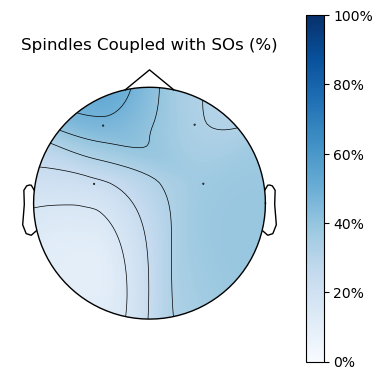

Stage N2:
Preferred Phase:       3.141 rad
Modulation Index:      0.681
Mean Vector Length:    0.872
Rayleigh z:            410.231
p-value:               0.000
Coupling Density:      1.332
Stage SWS:
Preferred Phase:       -3.134 rad
Modulation Index:      0.633
Mean Vector Length:    0.698
Rayleigh z:            228.260
p-value:               0.000
Coupling Density:      1.676


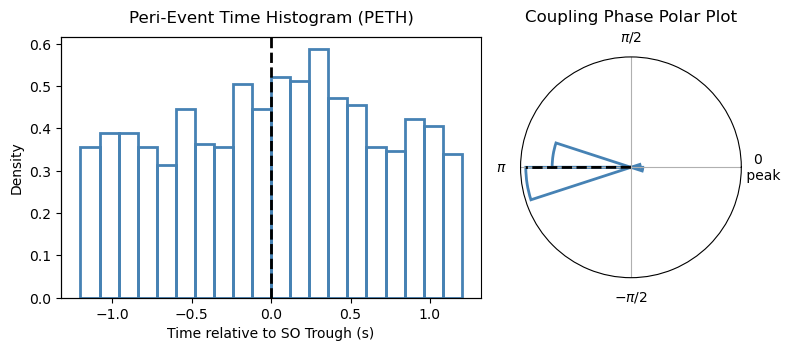

Start event detection for subject ITNS_102_W2_PM2_SD.
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Detected SOs in stage N2
Method: Staresina
PTP amplitude: 5844.8448
Mean Duration: 1.3797
SO Density per 30s: 1.5625
Total Count: 475
---------------------------------------------------------------
Detected SOs in stage SWS
Method: Staresina
PTP amplitude: 1049.6489
Mean Duration: 1.3815
SO Density per 30s: 2.8377
Total Count: 647
---------------------------------------------------------------
Detected SPs in stage N2
Method: Hahn2020
Average Amplitude: 462.4435 uv
Average Duration: 1.0983s
Spindle Density (per 30s): 2.8980
Total Spindle Count: 881
---------------------------------------------------------------
Detected SPs in stage SWS
Method: Hahn2020
Average Amplitude: 231.6038 uv
Average Duration: 1.6153s
Spindle Density (per 30s): 2.1316
Total Spindle Count: 486
---------------------------------------------------------------
Spindles coupled with SO

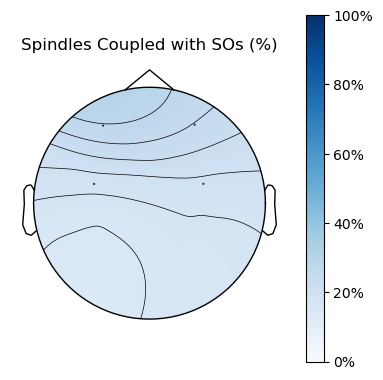

Stage N2:
Preferred Phase:       -0.007 rad
Modulation Index:      0.610
Mean Vector Length:    0.658
Rayleigh z:            68.802
p-value:               0.000
Coupling Density:      0.638
Stage SWS:
Preferred Phase:       -0.017 rad
Modulation Index:      0.597
Mean Vector Length:    0.956
Rayleigh z:            88.574
p-value:               0.000
Coupling Density:      0.500


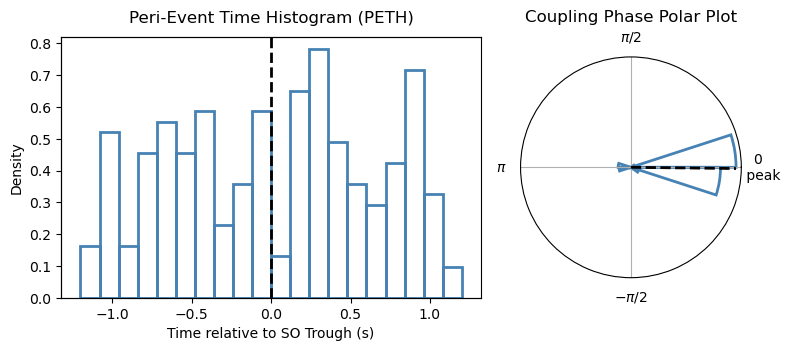

Start event detection for subject ITNS_102_W3_PM1.
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Detected SOs in stage N2
Method: Staresina
PTP amplitude: 157.6768
Mean Duration: 1.4151
SO Density per 30s: 2.3780
Total Count: 1208
---------------------------------------------------------------
Detected SOs in stage SWS
Method: Staresina
PTP amplitude: 239.6820
Mean Duration: 1.3627
SO Density per 30s: 3.1250
Total Count: 900
---------------------------------------------------------------
Detected SPs in stage N2
Method: Hahn2020
Average Amplitude: 19.5035 uv
Average Duration: 0.8915s
Spindle Density (per 30s): 4.0295
Total Spindle Count: 2047
---------------------------------------------------------------
Detected SPs in stage SWS
Method: Hahn2020
Average Amplitude: 19.5688 uv
Average Duration: 0.9278s
Spindle Density (per 30s): 4.1944
Total Spindle Count: 1208
---------------------------------------------------------------
Spindles coupled with SOs in

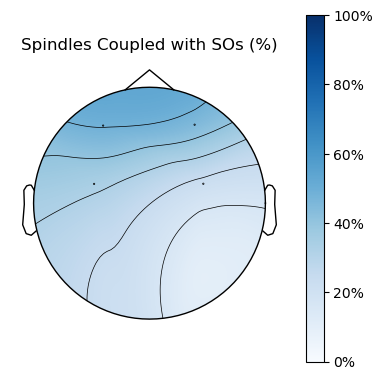

Stage N2:
Preferred Phase:       -3.109 rad
Modulation Index:      0.499
Mean Vector Length:    0.087
Rayleigh z:            4.423
p-value:               0.065
Coupling Density:      1.378
Stage SWS:
Preferred Phase:       -3.085 rad
Modulation Index:      0.405
Mean Vector Length:    0.102
Rayleigh z:            4.321
p-value:               0.071
Coupling Density:      1.774


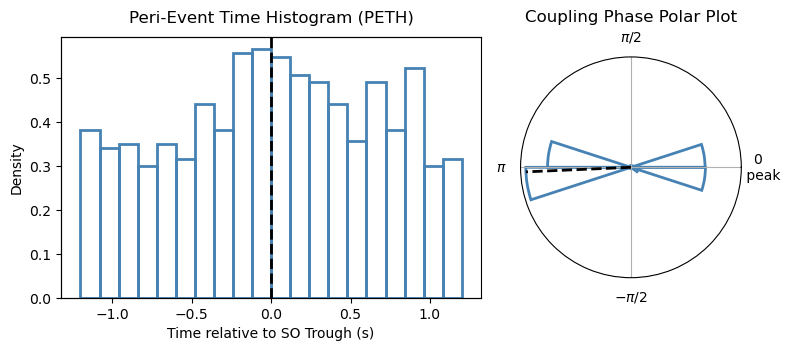

Start event detection for subject ITNS_102_W3_PM2_SD.
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Detected SOs in stage N2
Method: Staresina
PTP amplitude: 159.7170
Mean Duration: 1.4174
SO Density per 30s: 2.3061
Total Count: 987
---------------------------------------------------------------
Detected SOs in stage SWS
Method: Staresina
PTP amplitude: 248.9848
Mean Duration: 1.3696
SO Density per 30s: 2.9338
Total Count: 1197
---------------------------------------------------------------
Detected SPs in stage N2
Method: Hahn2020
Average Amplitude: 22.0409 uv
Average Duration: 0.8850s
Spindle Density (per 30s): 4.3995
Total Spindle Count: 1883
---------------------------------------------------------------
Detected SPs in stage SWS
Method: Hahn2020
Average Amplitude: 19.9103 uv
Average Duration: 0.8801s
Spindle Density (per 30s): 4.3260
Total Spindle Count: 1765
---------------------------------------------------------------
Spindles coupled with SOs

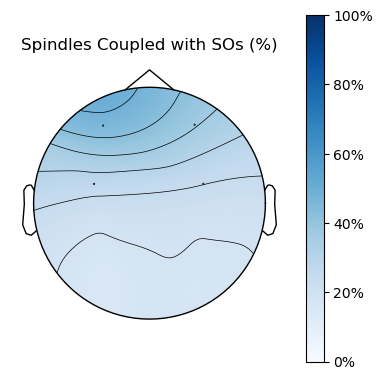

Stage N2:
Preferred Phase:       3.141 rad
Modulation Index:      0.770
Mean Vector Length:    1.000
Rayleigh z:            490.912
p-value:               0.000
Coupling Density:      1.364
Stage SWS:
Preferred Phase:       -3.139 rad
Modulation Index:      0.773
Mean Vector Length:    1.000
Rayleigh z:            528.913
p-value:               0.000
Coupling Density:      1.571


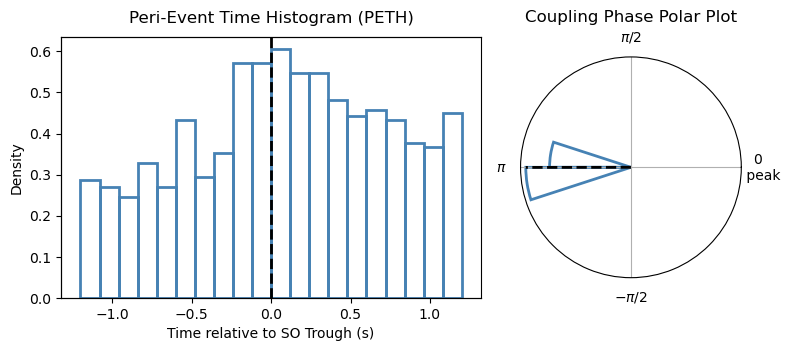

Start event detection for subject ITNS_103_W1_PM1_SD.
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Detected SOs in stage N2
Method: Staresina
PTP amplitude: 146.3753
Mean Duration: 1.4081
SO Density per 30s: 1.5040
Total Count: 379
---------------------------------------------------------------
Detected SOs in stage SWS
Method: Staresina
PTP amplitude: 192.1333
Mean Duration: 1.4011
SO Density per 30s: 1.6088
Total Count: 547
---------------------------------------------------------------
Detected SPs in stage N2
Method: Hahn2020
Average Amplitude: 25.4484 uv
Average Duration: 1.4214s
Spindle Density (per 30s): 3.9921
Total Spindle Count: 1006
---------------------------------------------------------------
Detected SPs in stage SWS
Method: Hahn2020
Average Amplitude: 24.1696 uv
Average Duration: 1.3744s
Spindle Density (per 30s): 4.0294
Total Spindle Count: 1370
---------------------------------------------------------------
Spindles coupled with SOs 

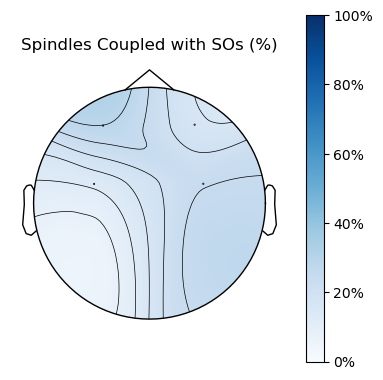

Stage N2:
Preferred Phase:       3.141 rad
Modulation Index:      0.772
Mean Vector Length:    1.000
Rayleigh z:            157.998
p-value:               0.000
Coupling Density:      0.718
Stage SWS:
Preferred Phase:       -3.141 rad
Modulation Index:      0.771
Mean Vector Length:    1.000
Rayleigh z:            249.995
p-value:               0.000
Coupling Density:      0.897


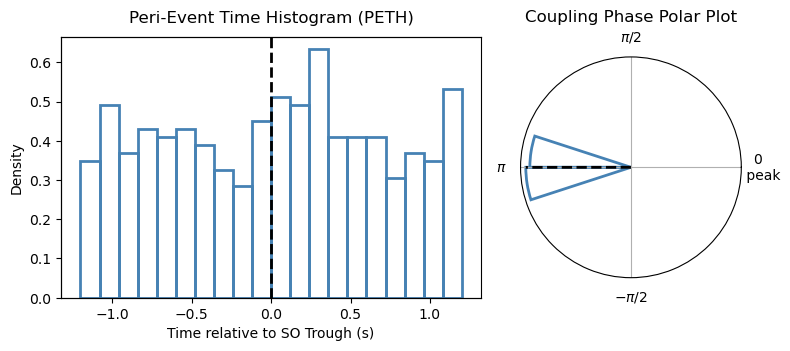

Start event detection for subject ITNS_103_W1_PM2_SD.
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Error parsing duration, defaulting to NaN: SLEEP-S0	POSITION-UNKNOWN	1:01:58 PM	SLEEP-S0	30
Error parsing duration, defaulting to NaN: SLEEP-S0	N/A	1:01:58 PM	RESERVED-SELECTION	0
Error parsing duration, defaulting to NaN: SLEEP-S0	N/A	1:01:58 PM	LIGHTS-OFF	0
Error parsing duration, defaulting to NaN: SLEEP-S0	POSITION-UNKNOWN	1:02:28 PM	SLEEP-S0	30
Error parsing duration, defaulting to NaN: SLEEP-S0	POSITION-UNKNOWN	1:02:58 PM	SLEEP-S0	30
Error parsing duration, defaulting to NaN: SLEEP-S0	POSITION-UNKNOWN	1:03:28 PM	SLEEP-S0	30
Error parsing duration, defaulting to NaN: SLEEP-S0	POSITION-UNKNOWN	1:03:58 PM	SLEEP-S0	30
Error parsing duration, defaulting to NaN: SLEEP-S0	POSITION-UNKNOWN	1:04:28 PM	SLEEP-S0	30
Error parsing duration, defaulting to NaN: SLEEP-S0	POSITION-UNKNOWN	1:04:58 PM	SLEEP-S0	30
Error parsing duration, defaulting to NaN: SLEEP-S0	PO

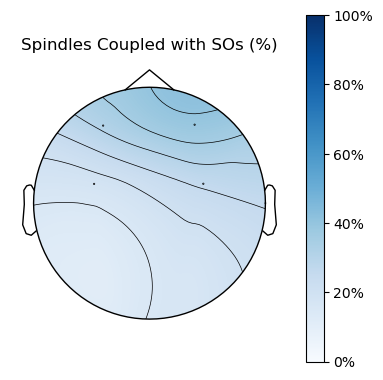

Stage N2:
Preferred Phase:       -3.132 rad
Modulation Index:      0.758
Mean Vector Length:    0.998
Rayleigh z:            281.882
p-value:               0.000
Coupling Density:      1.003
Stage SWS:
Preferred Phase:       -3.13 rad
Modulation Index:      0.667
Mean Vector Length:    0.847
Rayleigh z:            247.361
p-value:               0.000
Coupling Density:      1.244


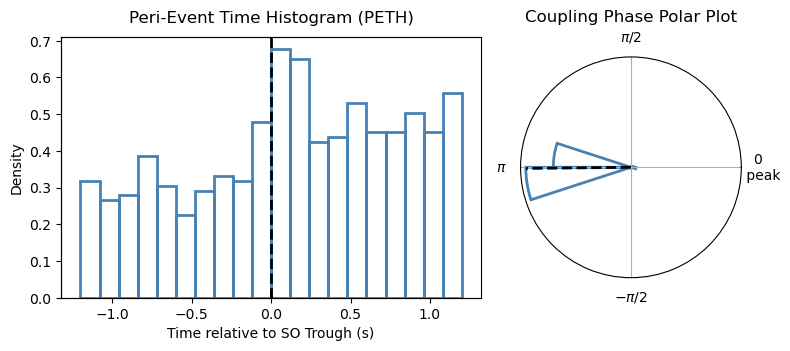

Start event detection for subject ITNS_103_W2_PM2.
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Detected SOs in stage N2
Method: Staresina
PTP amplitude: 90.3153
Mean Duration: 1.3325
SO Density per 30s: 3.1094
Total Count: 995
---------------------------------------------------------------
Detected SOs in stage SWS
Method: Staresina
PTP amplitude: 217.0247
Mean Duration: 1.3656
SO Density per 30s: 1.9405
Total Count: 163
---------------------------------------------------------------
Detected SPs in stage N2
Method: Hahn2020
Average Amplitude: 14.5163 uv
Average Duration: 0.8581s
Spindle Density (per 30s): 2.9750
Total Spindle Count: 952
---------------------------------------------------------------
Detected SPs in stage SWS
Method: Hahn2020
Average Amplitude: 19.9606 uv
Average Duration: 1.0737s
Spindle Density (per 30s): 3.7738
Total Spindle Count: 317
---------------------------------------------------------------
Spindles coupled with SOs in sta

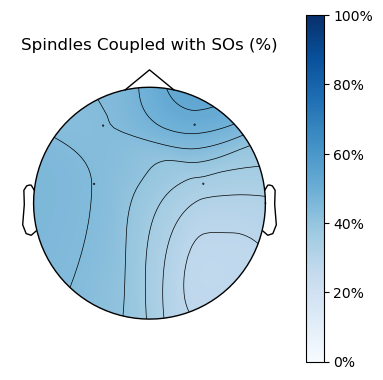

Stage N2:
Preferred Phase:       -3.14 rad
Modulation Index:      0.746
Mean Vector Length:    0.973
Rayleigh z:            358.174
p-value:               0.000
Coupling Density:      1.456
Stage SWS:
Preferred Phase:       -3.132 rad
Modulation Index:      0.779
Mean Vector Length:    0.999
Rayleigh z:            66.873
p-value:               0.000
Coupling Density:      0.964


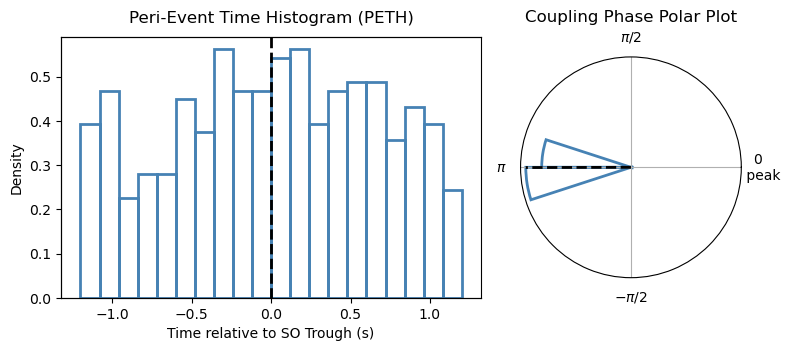

Start event detection for subject ITNS_103_W3_PM1.
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Detected SOs in stage N2
Method: Staresina
PTP amplitude: 177.3989
Mean Duration: 1.4095
SO Density per 30s: 1.2664
Total Count: 542
---------------------------------------------------------------
Detected SOs in stage SWS
Method: Staresina
PTP amplitude: 252.7908
Mean Duration: 1.3945
SO Density per 30s: 1.7714
Total Count: 829
---------------------------------------------------------------
Detected SPs in stage N2
Method: Hahn2020
Average Amplitude: 23.9775 uv
Average Duration: 1.1471s
Spindle Density (per 30s): 3.9673
Total Spindle Count: 1698
---------------------------------------------------------------
Detected SPs in stage SWS
Method: Hahn2020
Average Amplitude: 22.9052 uv
Average Duration: 1.2336s
Spindle Density (per 30s): 3.9466
Total Spindle Count: 1847
---------------------------------------------------------------
Spindles coupled with SOs in 

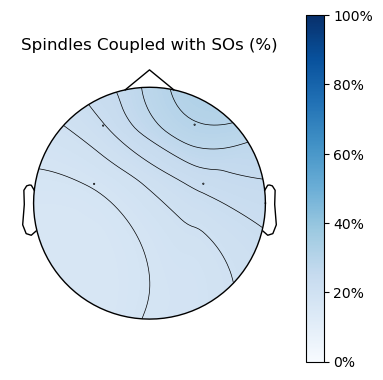

Stage N2:
Preferred Phase:       -3.139 rad
Modulation Index:      0.702
Mean Vector Length:    0.944
Rayleigh z:            247.663
p-value:               0.000
Coupling Density:      0.820
Stage SWS:
Preferred Phase:       -3.138 rad
Modulation Index:      0.725
Mean Vector Length:    0.950
Rayleigh z:            344.153
p-value:               0.000
Coupling Density:      1.011


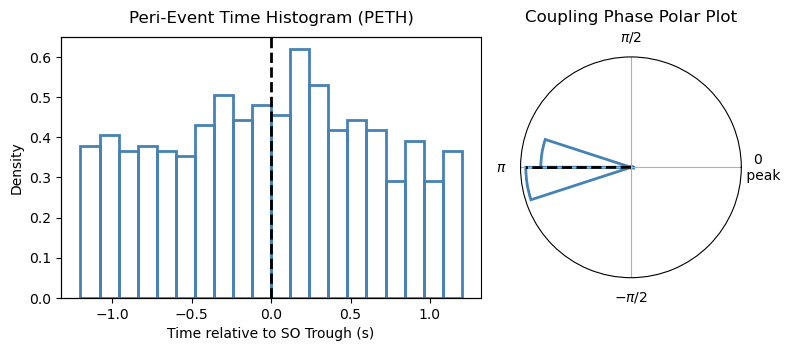

Start event detection for subject ITNS_103_W3_PM2_SD.
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Detected SOs in stage N2
Method: Staresina
PTP amplitude: 130.0451
Mean Duration: 1.4334
SO Density per 30s: 2.1622
Total Count: 960
---------------------------------------------------------------
Detected SOs in stage SWS
Method: Staresina
PTP amplitude: 235.2339
Mean Duration: 1.3437
SO Density per 30s: 2.2143
Total Count: 620
---------------------------------------------------------------
Detected SPs in stage N2
Method: Hahn2020
Average Amplitude: 20.5035 uv
Average Duration: 1.0206s
Spindle Density (per 30s): 3.8108
Total Spindle Count: 1692
---------------------------------------------------------------
Detected SPs in stage SWS
Method: Hahn2020
Average Amplitude: 22.2143 uv
Average Duration: 1.1778s
Spindle Density (per 30s): 4.1286
Total Spindle Count: 1156
---------------------------------------------------------------
Spindles coupled with SOs 

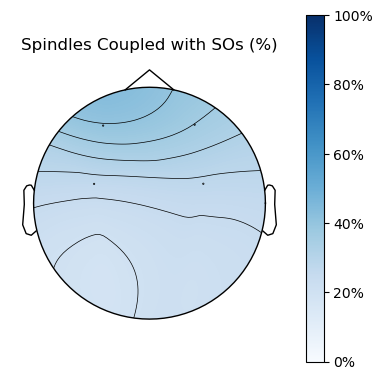

Stage N2:
Preferred Phase:       -3.14 rad
Modulation Index:      0.728
Mean Vector Length:    0.983
Rayleigh z:            433.074
p-value:               0.000
Coupling Density:      1.275
Stage SWS:
Preferred Phase:       -3.135 rad
Modulation Index:      0.644
Mean Vector Length:    0.867
Rayleigh z:            215.822
p-value:               0.000
Coupling Density:      1.250


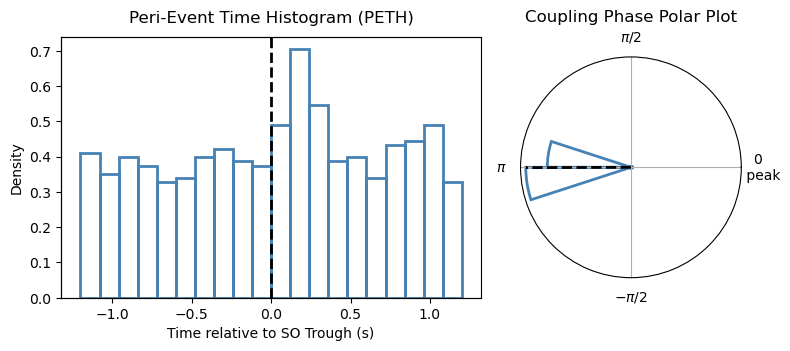

Start event detection for subject ITNS_112_W1_PM1.
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Detected SOs in stage N2
Method: Staresina
PTP amplitude: 130.8945
Mean Duration: 1.4108
SO Density per 30s: 2.6623
Total Count: 607
---------------------------------------------------------------
Detected SOs in stage SWS
Method: Staresina
PTP amplitude: 185.7407
Mean Duration: 1.3366
SO Density per 30s: 3.2431
Total Count: 467
---------------------------------------------------------------
Detected SPs in stage N2
Method: Hahn2020
Average Amplitude: 16.2614 uv
Average Duration: 0.8423s
Spindle Density (per 30s): 3.2544
Total Spindle Count: 742
---------------------------------------------------------------
Detected SPs in stage SWS
Method: Hahn2020
Average Amplitude: 20.3165 uv
Average Duration: 0.9685s
Spindle Density (per 30s): 4.0556
Total Spindle Count: 584
---------------------------------------------------------------
Spindles coupled with SOs in st

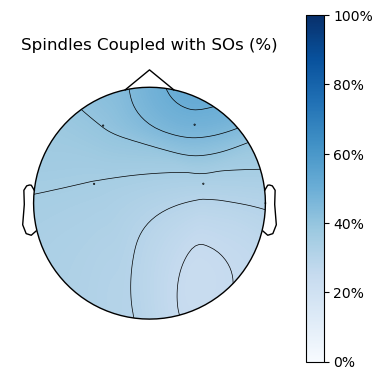

Stage N2:
Preferred Phase:       3.141 rad
Modulation Index:      0.769
Mean Vector Length:    1.000
Rayleigh z:            224.949
p-value:               0.000
Coupling Density:      1.149
Stage SWS:
Preferred Phase:       -3.141 rad
Modulation Index:      0.769
Mean Vector Length:    1.000
Rayleigh z:            218.961
p-value:               0.000
Coupling Density:      1.778


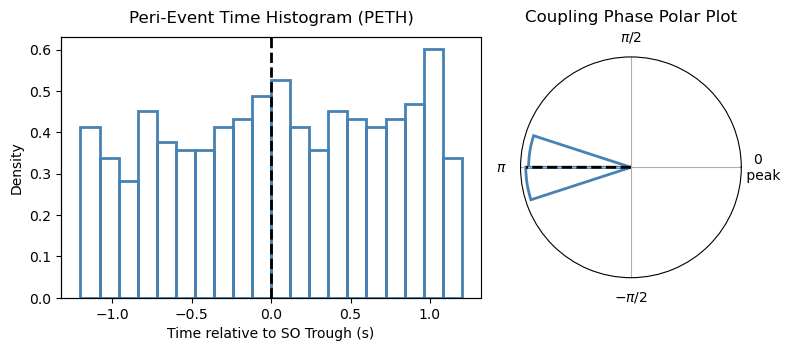

Start event detection for subject ITNS_112_W1_PM2_SD.
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Detected SOs in stage N2
Method: Staresina
PTP amplitude: 187.9925
Mean Duration: 1.3739
SO Density per 30s: 2.4755
Total Count: 505
---------------------------------------------------------------
Detected SOs in stage SWS
Method: Staresina
PTP amplitude: 204.2520
Mean Duration: 1.3558
SO Density per 30s: 2.8596
Total Count: 1018
---------------------------------------------------------------
Detected SPs in stage N2
Method: Hahn2020
Average Amplitude: 34.6121 uv
Average Duration: 1.0650s
Spindle Density (per 30s): 3.7108
Total Spindle Count: 757
---------------------------------------------------------------
Detected SPs in stage SWS
Method: Hahn2020
Average Amplitude: 18.1058 uv
Average Duration: 1.1335s
Spindle Density (per 30s): 3.4944
Total Spindle Count: 1244
---------------------------------------------------------------
Spindles coupled with SOs 

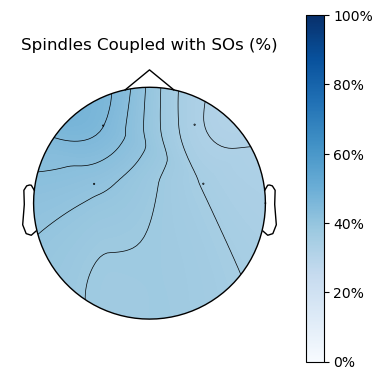

Stage N2:
Preferred Phase:       -0.0 rad
Modulation Index:      0.622
Mean Vector Length:    0.840
Rayleigh z:            169.175
p-value:               0.000
Coupling Density:      1.485
Stage SWS:
Preferred Phase:       0.002 rad
Modulation Index:      0.662
Mean Vector Length:    0.851
Rayleigh z:            284.292
p-value:               0.000
Coupling Density:      1.306


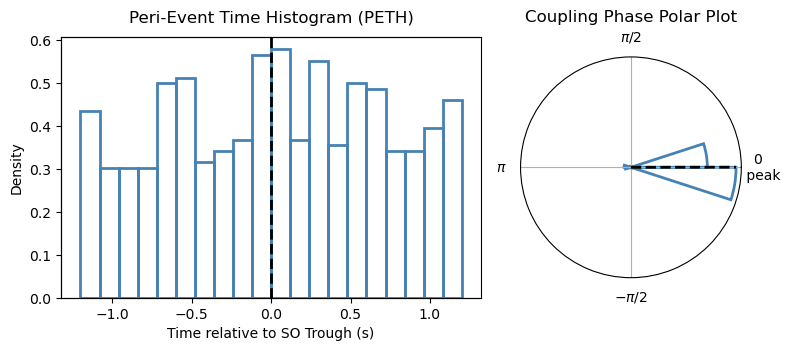

Start event detection for subject ITNS_112_W2_PM1.
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Detected SOs in stage N2
Method: Staresina
PTP amplitude: 188.2167
Mean Duration: 1.4398
SO Density per 30s: 1.9328
Total Count: 719
---------------------------------------------------------------
Detected SOs in stage SWS
Method: Staresina
PTP amplitude: 278.0006
Mean Duration: 1.4211
SO Density per 30s: 2.3836
Total Count: 553
---------------------------------------------------------------
Detected SPs in stage N2
Method: Hahn2020
Average Amplitude: 17.6039 uv
Average Duration: 0.8290s
Spindle Density (per 30s): 3.4462
Total Spindle Count: 1282
---------------------------------------------------------------
Detected SPs in stage SWS
Method: Hahn2020
Average Amplitude: 20.5053 uv
Average Duration: 0.9054s
Spindle Density (per 30s): 3.5000
Total Spindle Count: 812
---------------------------------------------------------------
Spindles coupled with SOs in s

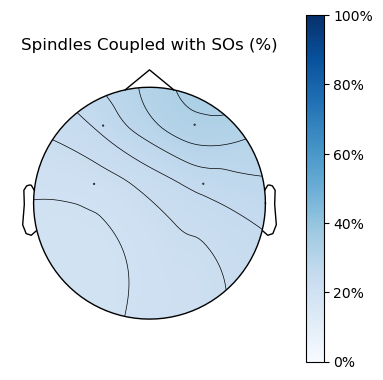

Stage N2:
Preferred Phase:       0.0 rad
Modulation Index:      0.554
Mean Vector Length:    0.448
Rayleigh z:            45.079
p-value:               0.000
Coupling Density:      0.758
Stage SWS:
Preferred Phase:       -0.018 rad
Modulation Index:      0.426
Mean Vector Length:    0.524
Rayleigh z:            60.388
p-value:               0.000
Coupling Density:      1.147


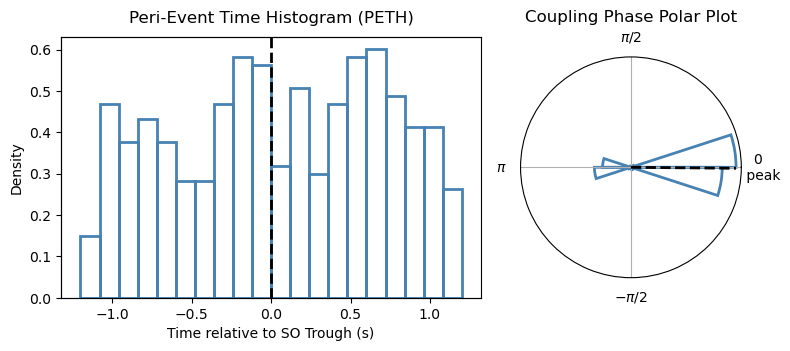

Start event detection for subject ITNS_112_W2_PM2.
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Detected SOs in stage N2
Method: Staresina
PTP amplitude: 58.3294
Mean Duration: 1.3865
SO Density per 30s: 2.4597
Total Count: 610
---------------------------------------------------------------
Detected SPs in stage N2
Method: Hahn2020
Average Amplitude: 5.1561 uv
Average Duration: 0.9261s
Spindle Density (per 30s): 3.6492
Total Spindle Count: 905
---------------------------------------------------------------
Spindles coupled with SOs in stage N2: 30.17%
SOs coupled with spindles in stage N2: 44.75%
event_summary
    stage channel_x  stage_dur  mean_SO_amp  mean_SO_dur  SO_density channel_y  \
0      2       all       1860     0.000058     1.386534    2.459677       all   
1      2       all       1860     0.000058     1.386534    2.459677        F3   
2      2       all       1860     0.000058     1.386534    2.459677        F4   
3      2       all    

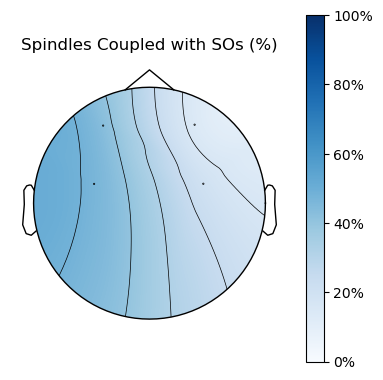

Stage N2:
Preferred Phase:       0.012 rad
Modulation Index:      0.579
Mean Vector Length:    0.619
Rayleigh z:            84.719
p-value:               0.000
Coupling Density:      1.101


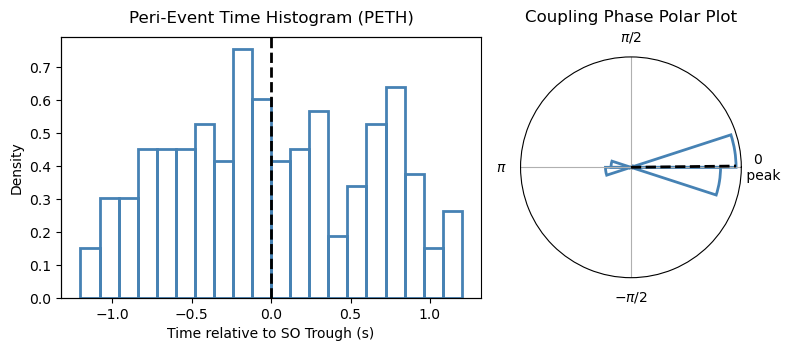

Start event detection for subject ITNS_112_W3_PM1.
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Detected SOs in stage N2
Method: Staresina
PTP amplitude: 131.2157
Mean Duration: 1.3936
SO Density per 30s: 2.9474
Total Count: 672
---------------------------------------------------------------
Detected SPs in stage N2
Method: Hahn2020
Average Amplitude: 13.7189 uv
Average Duration: 0.7725s
Spindle Density (per 30s): 3.6930
Total Spindle Count: 842
---------------------------------------------------------------
Spindles coupled with SOs in stage N2: 25.77%
SOs coupled with spindles in stage N2: 32.29%
event_summary
    stage channel_x  stage_dur  mean_SO_amp  mean_SO_dur  SO_density channel_y  \
0      2       all       1710     0.000131     1.393595    2.947368       all   
1      2       all       1710     0.000131     1.393595    2.947368        F3   
2      2       all       1710     0.000131     1.393595    2.947368        F4   
3      2       all  

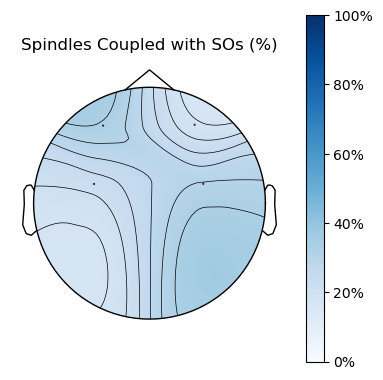

Stage N2:
Preferred Phase:       -0.043 rad
Modulation Index:      0.539
Mean Vector Length:    0.027
Rayleigh z:            0.135
p-value:               0.992
Coupling Density:      0.952


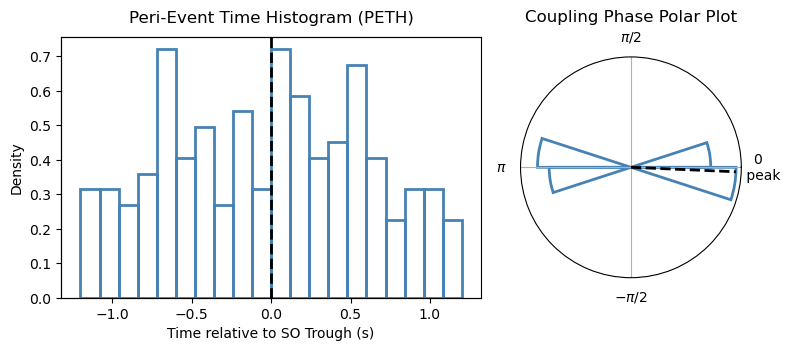

Start event detection for subject ITNS_112_W3_PM2.
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Detected SOs in stage N2
Method: Staresina
PTP amplitude: 189.3194
Mean Duration: 1.4072
SO Density per 30s: 1.5114
Total Count: 133
---------------------------------------------------------------
Detected SOs in stage SWS
Method: Staresina
PTP amplitude: 256.1349
Mean Duration: 1.3842
SO Density per 30s: 2.2759
Total Count: 528
---------------------------------------------------------------
Detected SPs in stage N2
Method: Hahn2020
Average Amplitude: 22.1814 uv
Average Duration: 0.8045s
Spindle Density (per 30s): 3.7841
Total Spindle Count: 333
---------------------------------------------------------------
Detected SPs in stage SWS
Method: Hahn2020
Average Amplitude: 17.9265 uv
Average Duration: 0.8044s
Spindle Density (per 30s): 3.5560
Total Spindle Count: 825
---------------------------------------------------------------
Spindles coupled with SOs in st

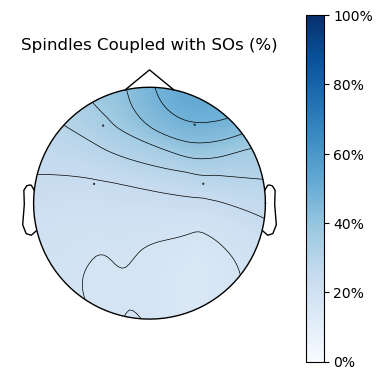

Stage N2:
Preferred Phase:       -3.138 rad
Modulation Index:      0.770
Mean Vector Length:    1.000
Rayleigh z:            52.951
p-value:               0.000
Coupling Density:      0.693
Stage SWS:
Preferred Phase:       -3.14 rad
Modulation Index:      0.495
Mean Vector Length:    0.437
Rayleigh z:            51.535
p-value:               0.000
Coupling Density:      1.401


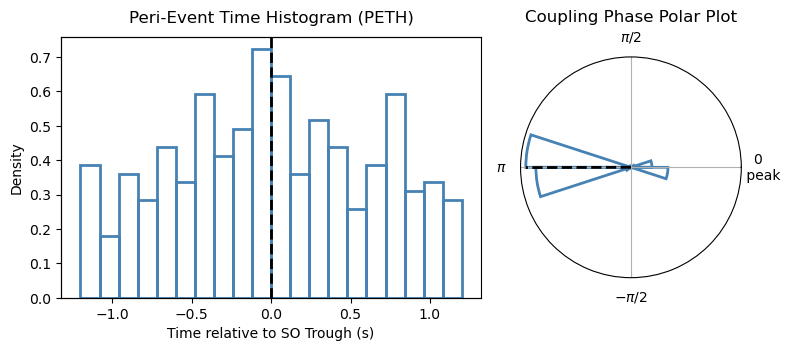

Start event detection for subject ITNS_113_W1_PM1.
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Detected SOs in stage N2
Method: Staresina
PTP amplitude: 202.2149
Mean Duration: 1.3944
SO Density per 30s: 1.6136
Total Count: 355
---------------------------------------------------------------
Detected SOs in stage SWS
Method: Staresina
PTP amplitude: 306.8419
Mean Duration: 1.3491
SO Density per 30s: 1.9436
Total Count: 793
---------------------------------------------------------------
Detected SPs in stage N2
Method: Hahn2020
Average Amplitude: 18.2807 uv
Average Duration: 1.0733s
Spindle Density (per 30s): 3.1545
Total Spindle Count: 694
---------------------------------------------------------------
Detected SPs in stage SWS
Method: Hahn2020
Average Amplitude: 15.8730 uv
Average Duration: 0.9235s
Spindle Density (per 30s): 3.3946
Total Spindle Count: 1385
---------------------------------------------------------------
Spindles coupled with SOs in s

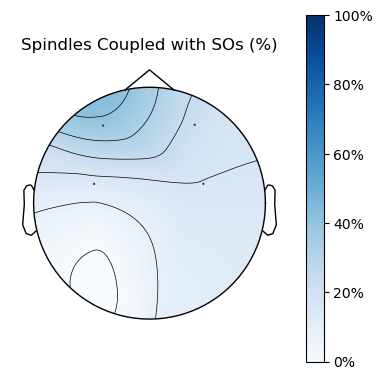

Stage N2:
Preferred Phase:       -3.138 rad
Modulation Index:      0.752
Mean Vector Length:    0.999
Rayleigh z:            99.817
p-value:               0.000
Coupling Density:      0.636
Stage SWS:
Preferred Phase:       -3.14 rad
Modulation Index:      0.775
Mean Vector Length:    1.000
Rayleigh z:            264.967
p-value:               0.000
Coupling Density:      0.782


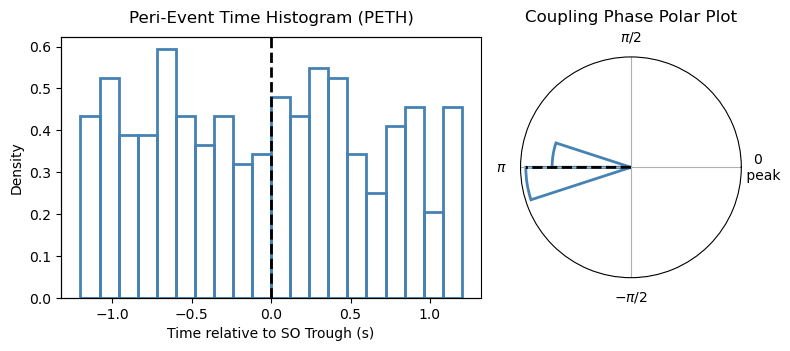

Start event detection for subject ITNS_113_W1_PM2.
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Detected SOs in stage N2
Method: Staresina
PTP amplitude: 133.6390
Mean Duration: 1.3128
SO Density per 30s: 3.1890
Total Count: 1097
---------------------------------------------------------------
Detected SOs in stage SWS
Method: Staresina
PTP amplitude: 272.4758
Mean Duration: 1.2639
SO Density per 30s: 3.3385
Total Count: 868
---------------------------------------------------------------
Detected SPs in stage N2
Method: Hahn2020
Average Amplitude: 12.2206 uv
Average Duration: 0.8447s
Spindle Density (per 30s): 2.7791
Total Spindle Count: 956
---------------------------------------------------------------
Detected SPs in stage SWS
Method: Hahn2020
Average Amplitude: 15.7270 uv
Average Duration: 0.7991s
Spindle Density (per 30s): 3.4577
Total Spindle Count: 899
---------------------------------------------------------------
Spindles coupled with SOs in s

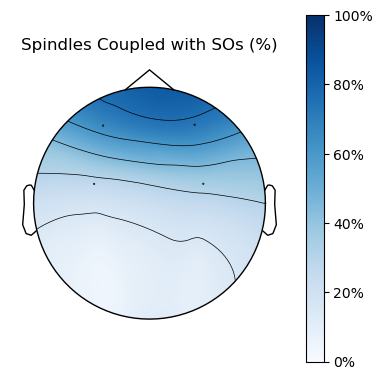

Stage N2:
Preferred Phase:       3.141 rad
Modulation Index:      0.770
Mean Vector Length:    1.000
Rayleigh z:            409.928
p-value:               0.000
Coupling Density:      1.442
Stage SWS:
Preferred Phase:       -3.141 rad
Modulation Index:      0.769
Mean Vector Length:    1.000
Rayleigh z:            351.966
p-value:               0.000
Coupling Density:      1.646


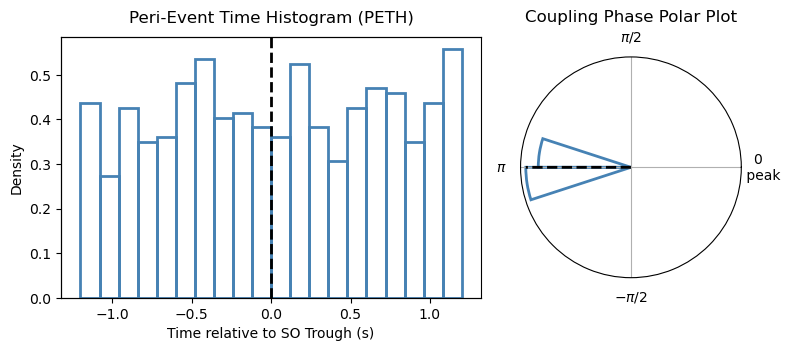

Start event detection for subject ITNS_113_W2_PM1.
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Detected SOs in stage N2
Method: Staresina
PTP amplitude: 195.3999
Mean Duration: 1.3733
SO Density per 30s: 2.4821
Total Count: 973
---------------------------------------------------------------
Detected SOs in stage SWS
Method: Staresina
PTP amplitude: 419.2691
Mean Duration: 1.2774
SO Density per 30s: 2.8198
Total Count: 970
---------------------------------------------------------------
Detected SPs in stage N2
Method: Hahn2020
Average Amplitude: 14.8574 uv
Average Duration: 0.8551s
Spindle Density (per 30s): 2.8138
Total Spindle Count: 1103
---------------------------------------------------------------
Detected SPs in stage SWS
Method: Hahn2020
Average Amplitude: 16.3471 uv
Average Duration: 0.8341s
Spindle Density (per 30s): 3.2587
Total Spindle Count: 1121
---------------------------------------------------------------
Spindles coupled with SOs in 

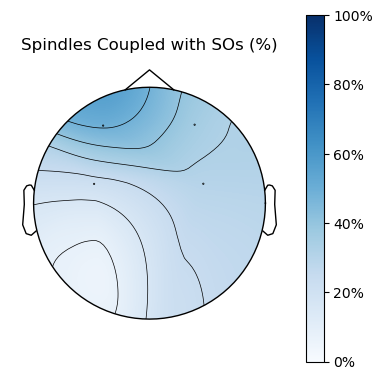

Stage N2:
Preferred Phase:       3.136 rad
Modulation Index:      0.547
Mean Vector Length:    0.394
Rayleigh z:            50.635
p-value:               0.000
Coupling Density:      1.020
Stage SWS:
Preferred Phase:       -3.135 rad
Modulation Index:      0.756
Mean Vector Length:    0.991
Rayleigh z:            296.415
p-value:               0.000
Coupling Density:      1.058


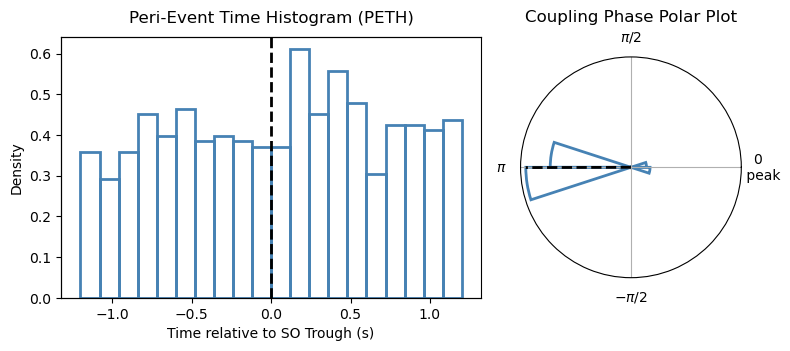

Start event detection for subject ITNS_113_W2_PM2_SD.
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Detected SOs in stage N2
Method: Staresina
PTP amplitude: 130.6613
Mean Duration: 1.3172
SO Density per 30s: 3.1082
Total Count: 833
---------------------------------------------------------------
Detected SOs in stage SWS
Method: Staresina
PTP amplitude: 269.7239
Mean Duration: 1.3189
SO Density per 30s: 3.4750
Total Count: 417
---------------------------------------------------------------
Detected SPs in stage N2
Method: Hahn2020
Average Amplitude: 10.8575 uv
Average Duration: 0.8223s
Spindle Density (per 30s): 2.4925
Total Spindle Count: 668
---------------------------------------------------------------
Detected SPs in stage SWS
Method: Hahn2020
Average Amplitude: 14.3592 uv
Average Duration: 0.9150s
Spindle Density (per 30s): 3.4083
Total Spindle Count: 409
---------------------------------------------------------------
Spindles coupled with SOs in

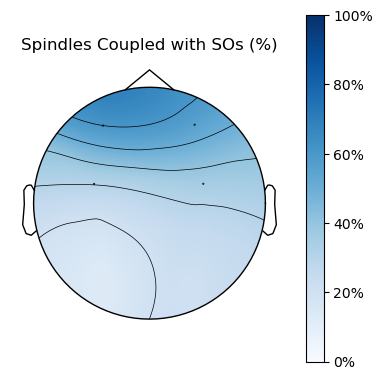

Stage N2:
Preferred Phase:       -3.13 rad
Modulation Index:      0.540
Mean Vector Length:    0.086
Rayleigh z:            1.808
p-value:               0.460
Coupling Density:      1.119
Stage SWS:
Preferred Phase:       0.004 rad
Modulation Index:      0.544
Mean Vector Length:    0.163
Rayleigh z:            3.756
p-value:               0.111
Coupling Density:      1.517


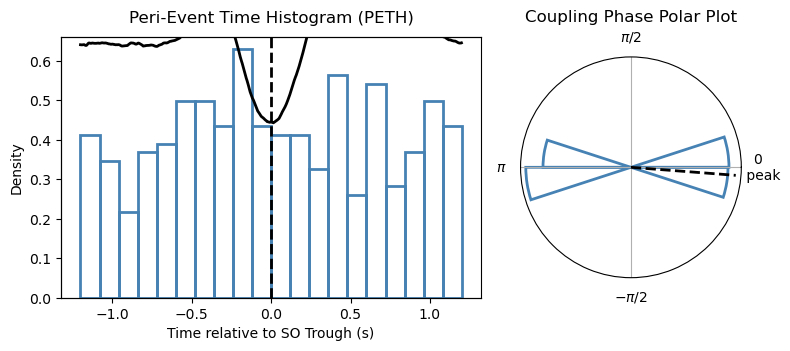

Start event detection for subject ITNS_113_W3_PM2_SD.
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Detected SOs in stage N2
Method: Staresina
PTP amplitude: 119.1089
Mean Duration: 1.4037
SO Density per 30s: 2.5893
Total Count: 1015
---------------------------------------------------------------
Detected SOs in stage SWS
Method: Staresina
PTP amplitude: 445.0102
Mean Duration: 1.3606
SO Density per 30s: 2.2787
Total Count: 793
---------------------------------------------------------------
Detected SPs in stage N2
Method: Hahn2020
Average Amplitude: 7.5292 uv
Average Duration: 0.7765s
Spindle Density (per 30s): 2.5051
Total Spindle Count: 982
---------------------------------------------------------------
Detected SPs in stage SWS
Method: Hahn2020
Average Amplitude: 14.5961 uv
Average Duration: 0.8943s
Spindle Density (per 30s): 3.5057
Total Spindle Count: 1220
---------------------------------------------------------------
Spindles coupled with SOs i

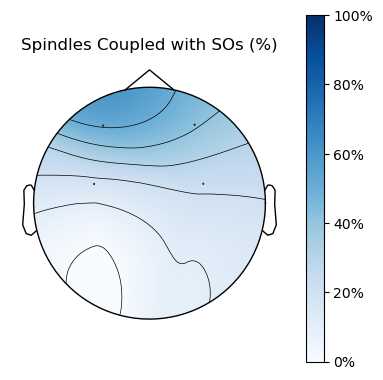

Stage N2:
Preferred Phase:       3.141 rad
Modulation Index:      0.769
Mean Vector Length:    1.000
Rayleigh z:            272.986
p-value:               0.000
Coupling Density:      0.880
Stage SWS:
Preferred Phase:       -3.141 rad
Modulation Index:      0.769
Mean Vector Length:    1.000
Rayleigh z:            310.886
p-value:               0.000
Coupling Density:      1.092


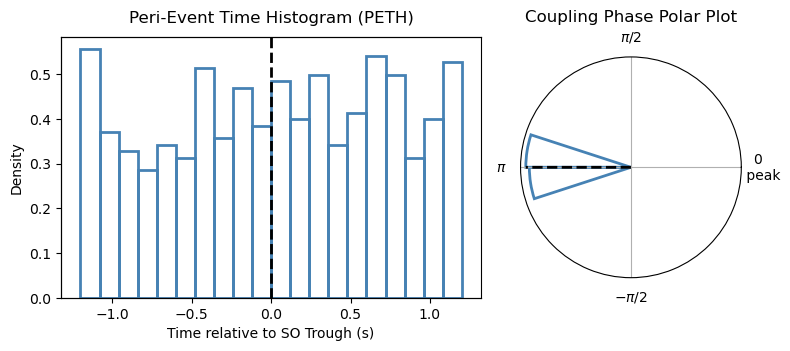

Start event detection for subject ITNS_119_W1_PM1_SD.
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Detected SOs in stage N2
Method: Staresina
PTP amplitude: 165.9734
Mean Duration: 1.3471
SO Density per 30s: 2.9375
Total Count: 799
---------------------------------------------------------------
Detected SOs in stage SWS
Method: Staresina
PTP amplitude: 246.1220
Mean Duration: 1.2932
SO Density per 30s: 3.6544
Total Count: 994
---------------------------------------------------------------
Detected SPs in stage N2
Method: Hahn2020
Average Amplitude: 18.4060 uv
Average Duration: 1.0854s
Spindle Density (per 30s): 3.6544
Total Spindle Count: 994
---------------------------------------------------------------
Detected SPs in stage SWS
Method: Hahn2020
Average Amplitude: 18.6196 uv
Average Duration: 1.2962s
Spindle Density (per 30s): 3.5772
Total Spindle Count: 973
---------------------------------------------------------------
Spindles coupled with SOs in

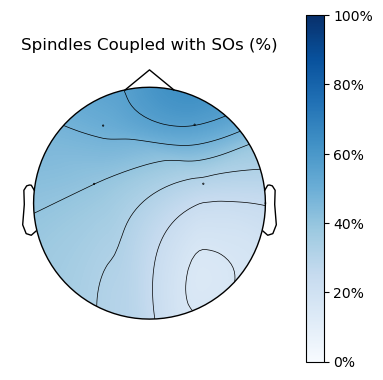

Stage N2:
Preferred Phase:       -3.141 rad
Modulation Index:      0.771
Mean Vector Length:    1.000
Rayleigh z:            333.991
p-value:               0.000
Coupling Density:      1.518
Stage SWS:
Preferred Phase:       -3.141 rad
Modulation Index:      0.769
Mean Vector Length:    1.000
Rayleigh z:            378.985
p-value:               0.000
Coupling Density:      1.665


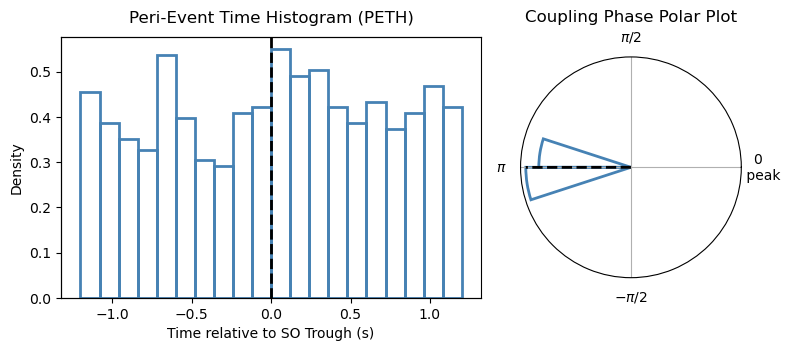

Start event detection for subject ITNS_119_W1_PM2_SD.
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Detected SOs in stage N2
Method: Staresina
PTP amplitude: 131.0142
Mean Duration: 1.3821
SO Density per 30s: 2.7112
Total Count: 1117
---------------------------------------------------------------
Detected SOs in stage SWS
Method: Staresina
PTP amplitude: 227.4025
Mean Duration: 1.2714
SO Density per 30s: 3.6304
Total Count: 334
---------------------------------------------------------------
Detected SPs in stage N2
Method: Hahn2020
Average Amplitude: 15.0010 uv
Average Duration: 0.7625s
Spindle Density (per 30s): 3.6044
Total Spindle Count: 1485
---------------------------------------------------------------
Detected SPs in stage SWS
Method: Hahn2020
Average Amplitude: 17.9411 uv
Average Duration: 0.8066s
Spindle Density (per 30s): 3.4674
Total Spindle Count: 319
---------------------------------------------------------------
Spindles coupled with SOs 

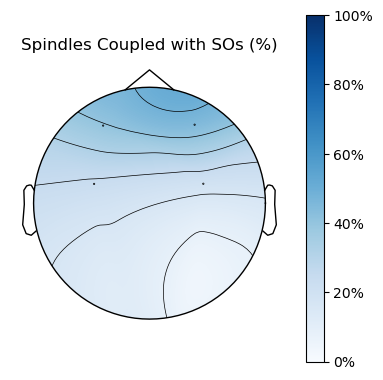

Stage N2:
Preferred Phase:       -3.14 rad
Modulation Index:      0.773
Mean Vector Length:    1.000
Rayleigh z:            358.980
p-value:               0.000
Coupling Density:      1.020
Stage SWS:
Preferred Phase:       -3.141 rad
Modulation Index:      0.772
Mean Vector Length:    1.000
Rayleigh z:            126.996
p-value:               0.000
Coupling Density:      1.620


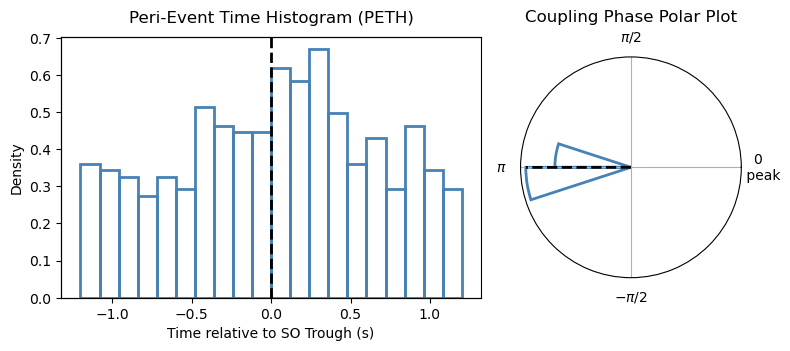

Start event detection for subject ITNS_119_W2_PM1_SD.
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Detected SOs in stage N2
Method: Staresina
PTP amplitude: 174.7232
Mean Duration: 1.4495
SO Density per 30s: 0.6818
Total Count: 60
---------------------------------------------------------------
Detected SOs in stage SWS
Method: Staresina
PTP amplitude: 299.3768
Mean Duration: 1.3779
SO Density per 30s: 1.3071
Total Count: 366
---------------------------------------------------------------
Detected SPs in stage N2
Method: Hahn2020
Average Amplitude: 19.2026 uv
Average Duration: 0.8667s
Spindle Density (per 30s): 3.6591
Total Spindle Count: 322
---------------------------------------------------------------
Detected SPs in stage SWS
Method: Hahn2020
Average Amplitude: 15.8898 uv
Average Duration: 0.9832s
Spindle Density (per 30s): 3.6607
Total Spindle Count: 1025
---------------------------------------------------------------
Spindles coupled with SOs in

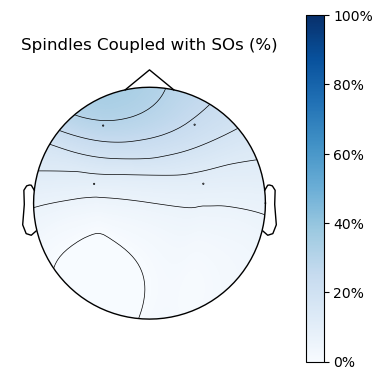

Stage N2:
Preferred Phase:       -3.141 rad
Modulation Index:      0.774
Mean Vector Length:    1.000
Rayleigh z:            22.000
p-value:               0.000
Coupling Density:      0.318
Stage SWS:
Preferred Phase:       -3.141 rad
Modulation Index:      0.769
Mean Vector Length:    1.000
Rayleigh z:            183.995
p-value:               0.000
Coupling Density:      0.754


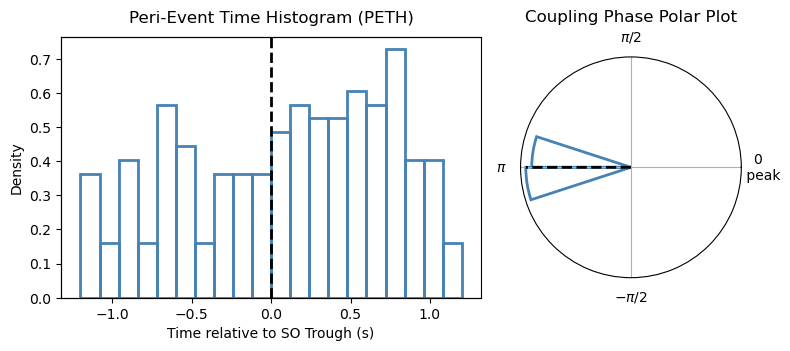

Start event detection for subject ITNS_119_W2_PM2_SD.
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Detected SOs in stage N2
Method: Staresina
PTP amplitude: 275.5070
Mean Duration: 1.4153
SO Density per 30s: 1.6648
Total Count: 586
---------------------------------------------------------------
Detected SOs in stage SWS
Method: Staresina
PTP amplitude: 517.9720
Mean Duration: 1.4067
SO Density per 30s: 1.9167
Total Count: 92
---------------------------------------------------------------
Detected SPs in stage N2
Method: Hahn2020
Average Amplitude: 20.8480 uv
Average Duration: 0.9091s
Spindle Density (per 30s): 3.6562
Total Spindle Count: 1287
---------------------------------------------------------------
Detected SPs in stage SWS
Method: Hahn2020
Average Amplitude: 37.0091 uv
Average Duration: 1.0057s
Spindle Density (per 30s): 4.0000
Total Spindle Count: 192
---------------------------------------------------------------
Spindles coupled with SOs in

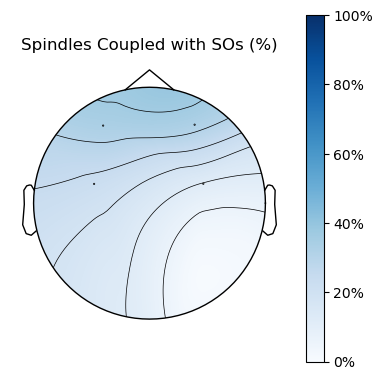

Stage N2:
Preferred Phase:       -3.131 rad
Modulation Index:      0.594
Mean Vector Length:    0.796
Rayleigh z:            160.375
p-value:               0.000
Coupling Density:      0.878
Stage SWS:
Preferred Phase:       -3.133 rad
Modulation Index:      0.645
Mean Vector Length:    0.871
Rayleigh z:            37.188
p-value:               0.000
Coupling Density:      1.188


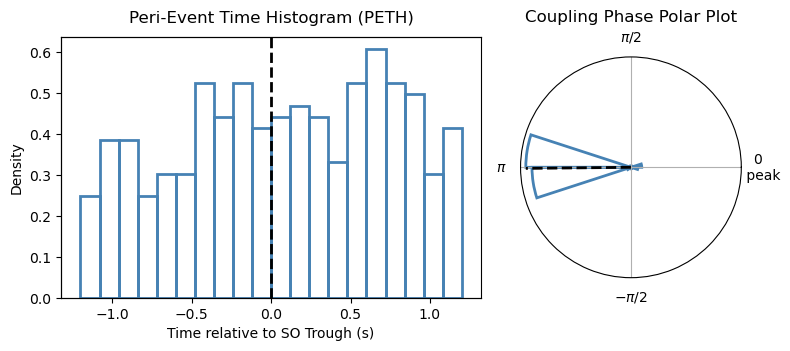

Start event detection for subject ITNS_119_W3_PM1_SD.
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Detected SOs in stage N2
Method: Staresina
PTP amplitude: 202.0793
Mean Duration: 1.3744
SO Density per 30s: 1.9759
Total Count: 656
---------------------------------------------------------------
Detected SOs in stage SWS
Method: Staresina
PTP amplitude: 305.8631
Mean Duration: 1.3377
SO Density per 30s: 2.2786
Total Count: 875
---------------------------------------------------------------
Detected SPs in stage N2
Method: Hahn2020
Average Amplitude: 13.8186 uv
Average Duration: 0.9254s
Spindle Density (per 30s): 3.6416
Total Spindle Count: 1209
---------------------------------------------------------------
Detected SPs in stage SWS
Method: Hahn2020
Average Amplitude: 14.1417 uv
Average Duration: 0.9003s
Spindle Density (per 30s): 3.5990
Total Spindle Count: 1382
---------------------------------------------------------------
Spindles coupled with SOs 

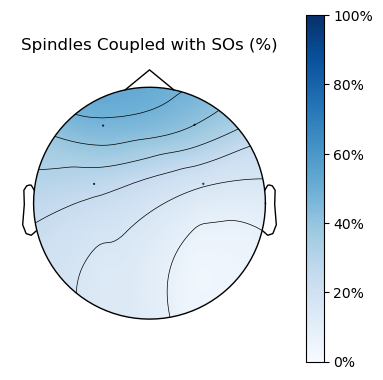

Stage N2:
Preferred Phase:       -3.139 rad
Modulation Index:      0.709
Mean Vector Length:    0.918
Rayleigh z:            266.075
p-value:               0.000
Coupling Density:      1.130
Stage SWS:
Preferred Phase:       3.14 rad
Modulation Index:      0.763
Mean Vector Length:    1.000
Rayleigh z:            400.629
p-value:               0.000
Coupling Density:      1.258


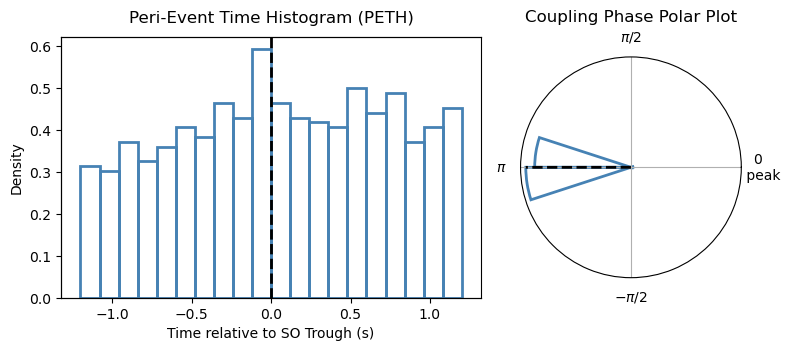

Start event detection for subject ITNS_119_W3_PM2_SD.
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Detected SOs in stage N2
Method: Staresina
PTP amplitude: 196.0882
Mean Duration: 1.4130
SO Density per 30s: 1.9472
Total Count: 553
---------------------------------------------------------------
Detected SOs in stage SWS
Method: Staresina
PTP amplitude: 285.9422
Mean Duration: 1.3732
SO Density per 30s: 2.6313
Total Count: 842
---------------------------------------------------------------
Detected SPs in stage N2
Method: Hahn2020
Average Amplitude: 15.5843 uv
Average Duration: 0.8615s
Spindle Density (per 30s): 3.6690
Total Spindle Count: 1042
---------------------------------------------------------------
Detected SPs in stage SWS
Method: Hahn2020
Average Amplitude: 16.3175 uv
Average Duration: 0.9209s
Spindle Density (per 30s): 3.7250
Total Spindle Count: 1192
---------------------------------------------------------------
Spindles coupled with SOs 

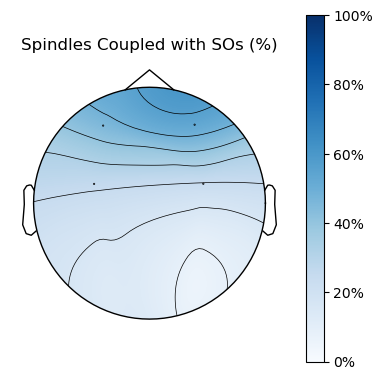

Stage N2:
Preferred Phase:       -3.136 rad
Modulation Index:      0.626
Mean Vector Length:    0.711
Rayleigh z:            144.243
p-value:               0.000
Coupling Density:      1.208
Stage SWS:
Preferred Phase:       -3.131 rad
Modulation Index:      0.581
Mean Vector Length:    0.677
Rayleigh z:            191.927
p-value:               0.000
Coupling Density:      1.525


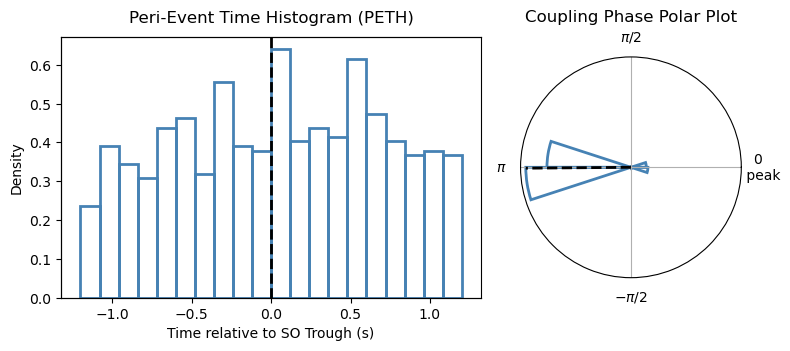

Start event detection for subject ITNS_122_W1_PM1_SD.
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Detected SOs in stage N2
Method: Staresina
PTP amplitude: 96.3830
Mean Duration: 1.3888
SO Density per 30s: 2.6014
Total Count: 770
---------------------------------------------------------------
Detected SOs in stage SWS
Method: Staresina
PTP amplitude: 142.5922
Mean Duration: 1.3032
SO Density per 30s: 3.2908
Total Count: 645
---------------------------------------------------------------
Detected SPs in stage N2
Method: Hahn2020
Average Amplitude: 17.0949 uv
Average Duration: 1.2200s
Spindle Density (per 30s): 3.6689
Total Spindle Count: 1086
---------------------------------------------------------------
Detected SPs in stage SWS
Method: Hahn2020
Average Amplitude: 19.0727 uv
Average Duration: 1.3340s
Spindle Density (per 30s): 4.1429
Total Spindle Count: 812
---------------------------------------------------------------
Spindles coupled with SOs in

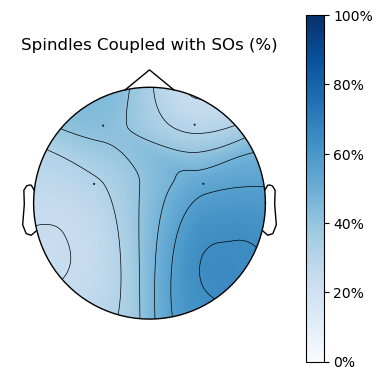

Stage N2:
Preferred Phase:       3.135 rad
Modulation Index:      0.603
Mean Vector Length:    0.648
Rayleigh z:            135.330
p-value:               0.000
Coupling Density:      1.351
Stage SWS:
Preferred Phase:       -3.141 rad
Modulation Index:      0.769
Mean Vector Length:    1.000
Rayleigh z:            280.877
p-value:               0.000
Coupling Density:      1.724


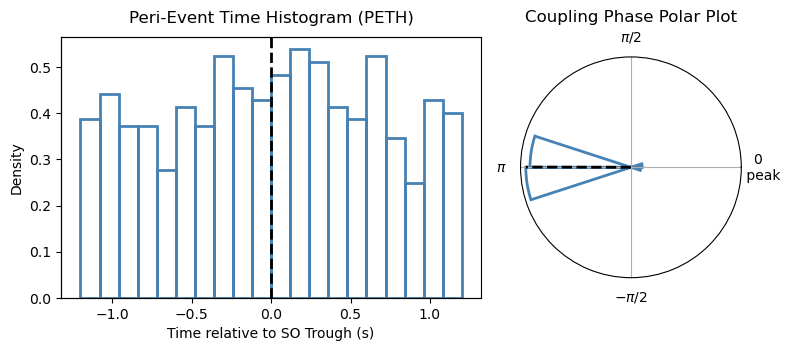

Start event detection for subject ITNS_122_W1_PM2.
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Detected SOs in stage N2
Method: Staresina
PTP amplitude: 321.1589
Mean Duration: 1.3221
SO Density per 30s: 2.6429
Total Count: 888
---------------------------------------------------------------
Detected SOs in stage SWS
Method: Staresina
PTP amplitude: 232.5870
Mean Duration: 1.2990
SO Density per 30s: 3.1867
Total Count: 956
---------------------------------------------------------------
Detected SPs in stage N2
Method: Hahn2020
Average Amplitude: 46.9623 uv
Average Duration: 1.2575s
Spindle Density (per 30s): 3.6994
Total Spindle Count: 1243
---------------------------------------------------------------
Detected SPs in stage SWS
Method: Hahn2020
Average Amplitude: 24.5944 uv
Average Duration: 1.2614s
Spindle Density (per 30s): 3.9800
Total Spindle Count: 1194
---------------------------------------------------------------
Spindles coupled with SOs in 

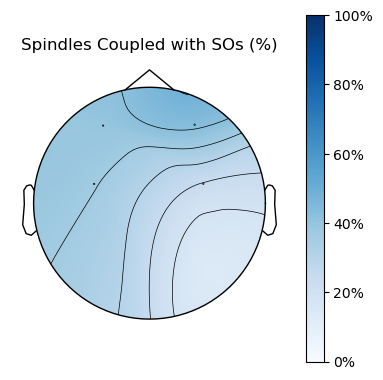

Stage N2:
Preferred Phase:       -0.319 rad
Modulation Index:      0.395
Mean Vector Length:    0.104
Rayleigh z:            3.487
p-value:               0.137
Coupling Density:      1.208
Stage SWS:
Preferred Phase:       -0.034 rad
Modulation Index:      0.537
Mean Vector Length:    0.396
Rayleigh z:            59.759
p-value:               0.000
Coupling Density:      1.537


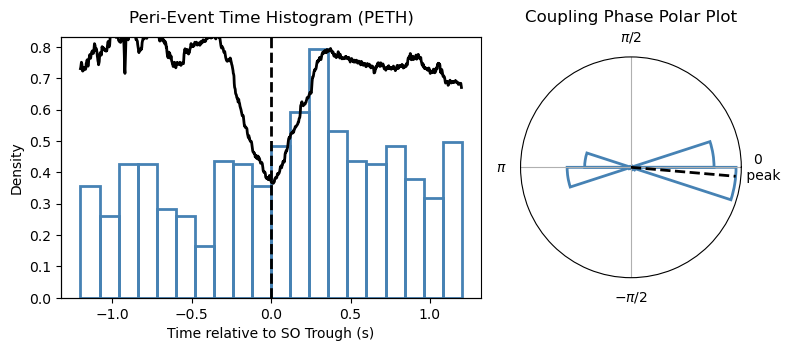

Start event detection for subject ITNS_122_W2_PM1_SD.
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Detected SOs in stage N2
Method: Staresina
PTP amplitude: 148.5221
Mean Duration: 1.3912
SO Density per 30s: 2.4688
Total Count: 316
---------------------------------------------------------------
Detected SOs in stage SWS
Method: Staresina
PTP amplitude: 230.9997
Mean Duration: 1.2987
SO Density per 30s: 3.2724
Total Count: 877
---------------------------------------------------------------
Detected SPs in stage N2
Method: Hahn2020
Average Amplitude: 20.0343 uv
Average Duration: 0.9792s
Spindle Density (per 30s): 3.4375
Total Spindle Count: 440
---------------------------------------------------------------
Detected SPs in stage SWS
Method: Hahn2020
Average Amplitude: 22.5344 uv
Average Duration: 1.2346s
Spindle Density (per 30s): 4.1940
Total Spindle Count: 1124
---------------------------------------------------------------
Spindles coupled with SOs i

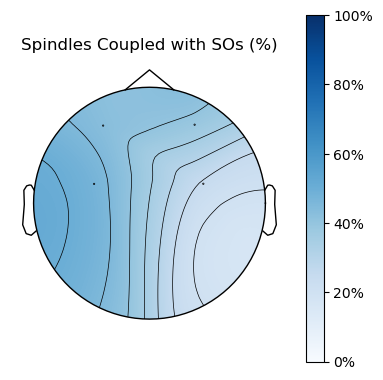

Stage N2:
Preferred Phase:       3.138 rad
Modulation Index:      0.757
Mean Vector Length:    0.998
Rayleigh z:            130.548
p-value:               0.000
Coupling Density:      1.242
Stage SWS:
Preferred Phase:       -3.136 rad
Modulation Index:      0.665
Mean Vector Length:    0.951
Rayleigh z:            334.912
p-value:               0.000
Coupling Density:      1.634


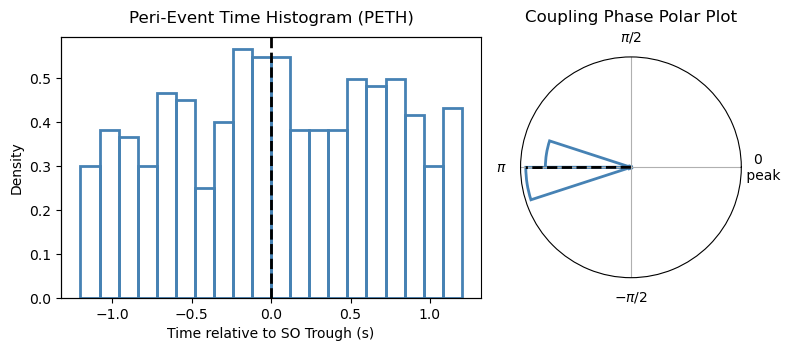

Start event detection for subject ITNS_122_W2_PM2_a_SD.
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Detected SOs in stage N2
Method: Staresina
PTP amplitude: 145.1547
Mean Duration: 1.3343
SO Density per 30s: 3.3636
Total Count: 296
---------------------------------------------------------------
Detected SOs in stage SWS
Method: Staresina
PTP amplitude: 230.5283
Mean Duration: 1.2672
SO Density per 30s: 3.6682
Total Count: 807
---------------------------------------------------------------
Detected SPs in stage N2
Method: Hahn2020
Average Amplitude: 18.1290 uv
Average Duration: 0.9058s
Spindle Density (per 30s): 3.1705
Total Spindle Count: 279
---------------------------------------------------------------
Detected SPs in stage SWS
Method: Hahn2020
Average Amplitude: 19.4033 uv
Average Duration: 1.0251s
Spindle Density (per 30s): 3.7273
Total Spindle Count: 820
---------------------------------------------------------------
Spindles coupled with SOs 

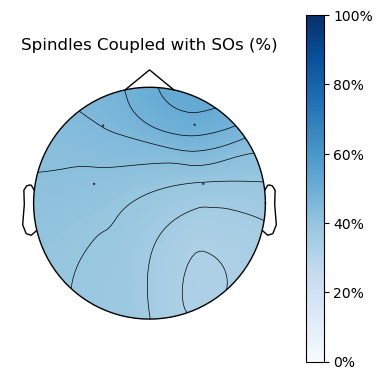

Stage N2:
Preferred Phase:       -3.134 rad
Modulation Index:      0.724
Mean Vector Length:    0.984
Rayleigh z:            104.626
p-value:               0.000
Coupling Density:      1.455
Stage SWS:
Preferred Phase:       -3.087 rad
Modulation Index:      0.476
Mean Vector Length:    0.488
Rayleigh z:            68.558
p-value:               0.000
Coupling Density:      1.614


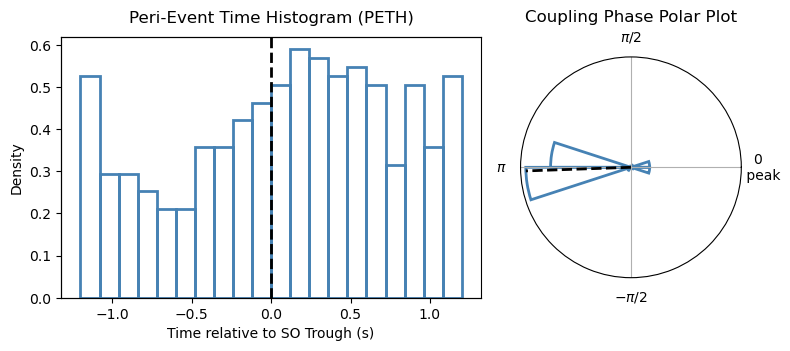

Start event detection for subject ITNS_122_W2_PM2_b_SD.
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Detected SOs in stage N2
Method: Staresina
PTP amplitude: 136.1458
Mean Duration: 1.3531
SO Density per 30s: 2.5135
Total Count: 372
---------------------------------------------------------------
Detected SOs in stage SWS
Method: Staresina
PTP amplitude: 205.3083
Mean Duration: 1.2817
SO Density per 30s: 3.6705
Total Count: 323
---------------------------------------------------------------
Detected SPs in stage N2
Method: Hahn2020
Average Amplitude: 16.6038 uv
Average Duration: 0.9990s
Spindle Density (per 30s): 3.4054
Total Spindle Count: 504
---------------------------------------------------------------
Detected SPs in stage SWS
Method: Hahn2020
Average Amplitude: 17.3302 uv
Average Duration: 1.0652s
Spindle Density (per 30s): 3.9318
Total Spindle Count: 346
---------------------------------------------------------------
Spindles coupled with SOs 

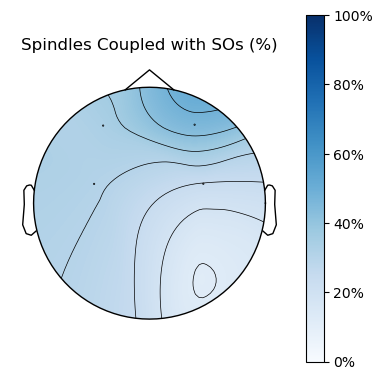

Stage N2:
Preferred Phase:       0.008 rad
Modulation Index:      0.559
Mean Vector Length:    0.502
Rayleigh z:            29.690
p-value:               0.000
Coupling Density:      0.973
Stage SWS:
Preferred Phase:       -0.036 rad
Modulation Index:      0.491
Mean Vector Length:    0.429
Rayleigh z:            22.453
p-value:               0.000
Coupling Density:      1.636


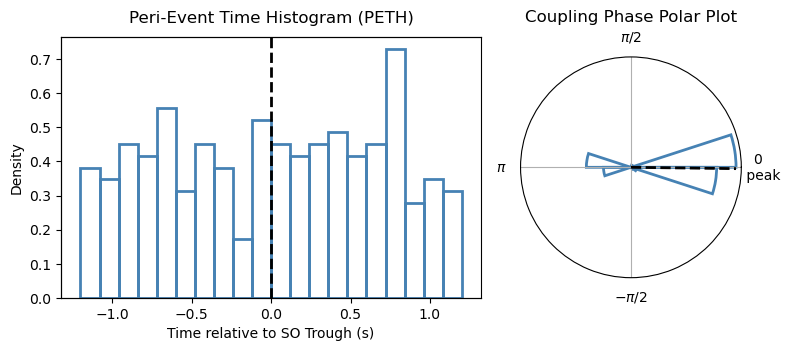

Start event detection for subject ITNS_122_W3_PM1_SD.
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Detected SOs in stage N2
Method: Staresina
PTP amplitude: 151.8916
Mean Duration: 1.3882
SO Density per 30s: 2.8897
Total Count: 393
---------------------------------------------------------------
Detected SOs in stage SWS
Method: Staresina
PTP amplitude: 264.6830
Mean Duration: 1.3626
SO Density per 30s: 3.2941
Total Count: 224
---------------------------------------------------------------
Detected SPs in stage N2
Method: Hahn2020
Average Amplitude: 19.5338 uv
Average Duration: 0.8851s
Spindle Density (per 30s): 3.2941
Total Spindle Count: 448
---------------------------------------------------------------
Detected SPs in stage SWS
Method: Hahn2020
Average Amplitude: 22.8168 uv
Average Duration: 1.0657s
Spindle Density (per 30s): 4.3235
Total Spindle Count: 294
---------------------------------------------------------------
Spindles coupled with SOs in

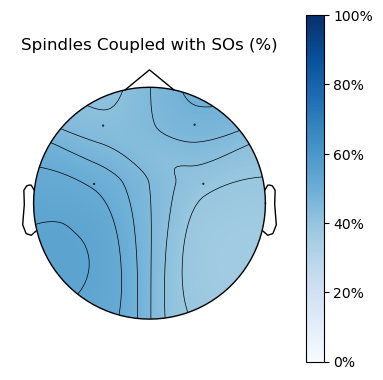

Stage N2:
Preferred Phase:       3.139 rad
Modulation Index:      0.775
Mean Vector Length:    1.000
Rayleigh z:            150.981
p-value:               0.000
Coupling Density:      1.441
Stage SWS:
Preferred Phase:       3.139 rad
Modulation Index:      0.779
Mean Vector Length:    1.000
Rayleigh z:            110.982
p-value:               0.000
Coupling Density:      2.044


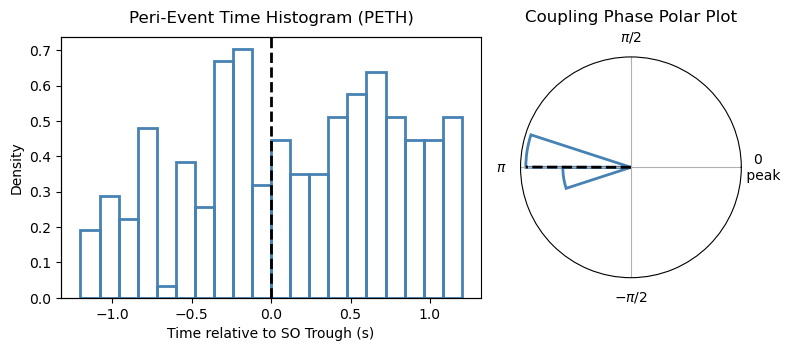

Start event detection for subject ITNS_122_W3_PM2.
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Detected SOs in stage N2
Method: Staresina
PTP amplitude: 167.8266
Mean Duration: 1.3601
SO Density per 30s: 2.1324
Total Count: 580
---------------------------------------------------------------
Detected SOs in stage SWS
Method: Staresina
PTP amplitude: 287.8292
Mean Duration: 1.3274
SO Density per 30s: 2.8705
Total Count: 1596
---------------------------------------------------------------
Detected SPs in stage N2
Method: Hahn2020
Average Amplitude: 18.5407 uv
Average Duration: 0.9241s
Spindle Density (per 30s): 3.7610
Total Spindle Count: 1023
---------------------------------------------------------------
Detected SPs in stage SWS
Method: Hahn2020
Average Amplitude: 21.7322 uv
Average Duration: 1.1608s
Spindle Density (per 30s): 4.1619
Total Spindle Count: 2314
---------------------------------------------------------------
Spindles coupled with SOs in

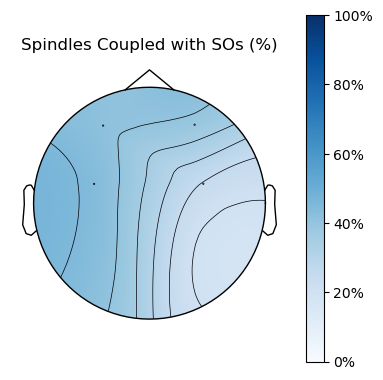

Stage N2:
Preferred Phase:       -3.133 rad
Modulation Index:      0.614
Mean Vector Length:    0.725
Rayleigh z:            147.866
p-value:               0.000
Coupling Density:      1.229
Stage SWS:
Preferred Phase:       -3.13 rad
Modulation Index:      0.572
Mean Vector Length:    0.667
Rayleigh z:            333.036
p-value:               0.000
Coupling Density:      1.622


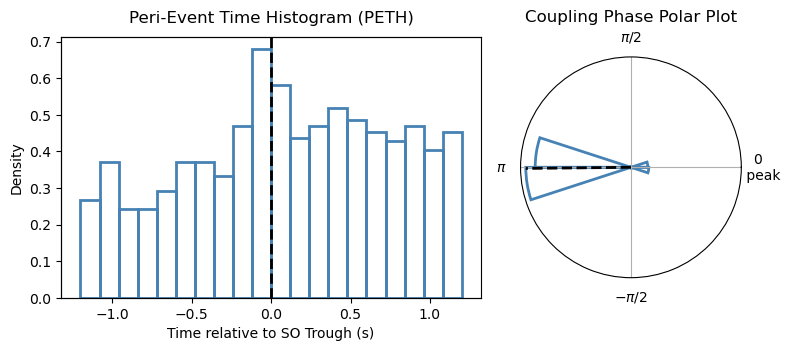

Start event detection for subject ITNS_18_W1_PM1.
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Detected SOs in stage N2
Method: Staresina
PTP amplitude: 171.2158
Mean Duration: 1.4277
SO Density per 30s: 2.1700
Total Count: 651
---------------------------------------------------------------
Detected SOs in stage SWS
Method: Staresina
PTP amplitude: 220.1623
Mean Duration: 1.3630
SO Density per 30s: 2.7254
Total Count: 774
---------------------------------------------------------------
Detected SPs in stage N2
Method: Hahn2020
Average Amplitude: 22.3010 uv
Average Duration: 1.2739s
Spindle Density (per 30s): 3.2967
Total Spindle Count: 989
---------------------------------------------------------------
Detected SPs in stage SWS
Method: Hahn2020
Average Amplitude: 18.9073 uv
Average Duration: 1.4183s
Spindle Density (per 30s): 3.7711
Total Spindle Count: 1071
---------------------------------------------------------------
Spindles coupled with SOs in st

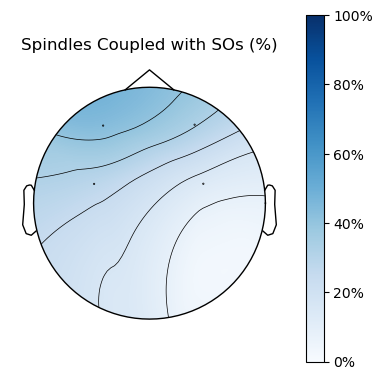

Stage N2:
Preferred Phase:       -0.003 rad
Modulation Index:      0.750
Mean Vector Length:    0.999
Rayleigh z:            200.529
p-value:               0.000
Coupling Density:      0.847
Stage SWS:
Preferred Phase:       -0.001 rad
Modulation Index:      0.770
Mean Vector Length:    1.000
Rayleigh z:            265.984
p-value:               0.000
Coupling Density:      1.187


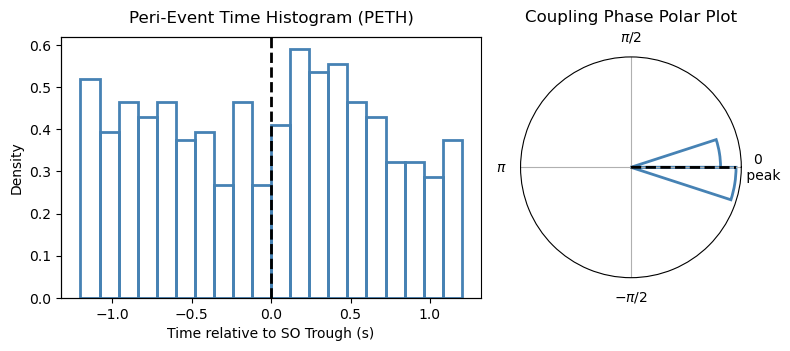

Start event detection for subject ITNS_18_W1_PM2.
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Detected SOs in stage N2
Method: Staresina
PTP amplitude: 145.7134
Mean Duration: 1.3719
SO Density per 30s: 3.3079
Total Count: 2514
---------------------------------------------------------------
Detected SOs in stage SWS
Method: Staresina
PTP amplitude: 215.1156
Mean Duration: 1.3500
SO Density per 30s: 3.2574
Total Count: 443
---------------------------------------------------------------
Detected SPs in stage N2
Method: Hahn2020
Average Amplitude: 34.2165 uv
Average Duration: 1.1677s
Spindle Density (per 30s): 2.7908
Total Spindle Count: 2121
---------------------------------------------------------------
Detected SPs in stage SWS
Method: Hahn2020
Average Amplitude: 20.4464 uv
Average Duration: 1.5470s
Spindle Density (per 30s): 3.4338
Total Spindle Count: 467
---------------------------------------------------------------
Spindles coupled with SOs in s

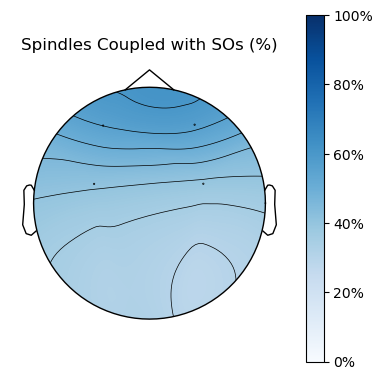

Stage N2:
Preferred Phase:       3.14 rad
Modulation Index:      0.572
Mean Vector Length:    0.503
Rayleigh z:            212.909
p-value:               0.000
Coupling Density:      1.391
Stage SWS:
Preferred Phase:       -3.132 rad
Modulation Index:      0.562
Mean Vector Length:    0.372
Rayleigh z:            19.355
p-value:               0.000
Coupling Density:      1.243


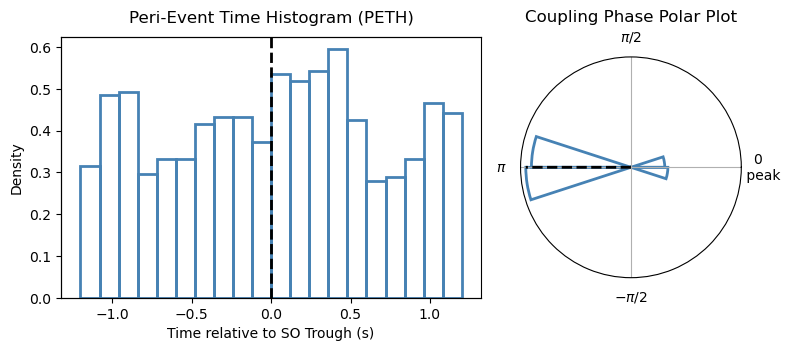

Start event detection for subject ITNS_18_W2_PM1.
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Detected SOs in stage N2
Method: Staresina
PTP amplitude: 171.8124
Mean Duration: 1.3651
SO Density per 30s: 2.8500
Total Count: 513
---------------------------------------------------------------
Detected SOs in stage SWS
Method: Staresina
PTP amplitude: 216.3250
Mean Duration: 1.3250
SO Density per 30s: 3.5938
Total Count: 690
---------------------------------------------------------------
Detected SPs in stage N2
Method: Hahn2020
Average Amplitude: 18.4034 uv
Average Duration: 1.0858s
Spindle Density (per 30s): 3.2111
Total Spindle Count: 578
---------------------------------------------------------------
Detected SPs in stage SWS
Method: Hahn2020
Average Amplitude: 15.8111 uv
Average Duration: 1.2407s
Spindle Density (per 30s): 3.7240
Total Spindle Count: 715
---------------------------------------------------------------
Spindles coupled with SOs in sta

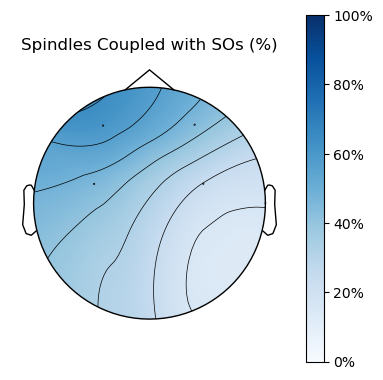

Stage N2:
Preferred Phase:       -3.093 rad
Modulation Index:      0.629
Mean Vector Length:    0.909
Rayleigh z:            161.969
p-value:               0.000
Coupling Density:      1.322
Stage SWS:
Preferred Phase:       3.138 rad
Modulation Index:      0.755
Mean Vector Length:    0.998
Rayleigh z:            269.178
p-value:               0.000
Coupling Density:      1.661


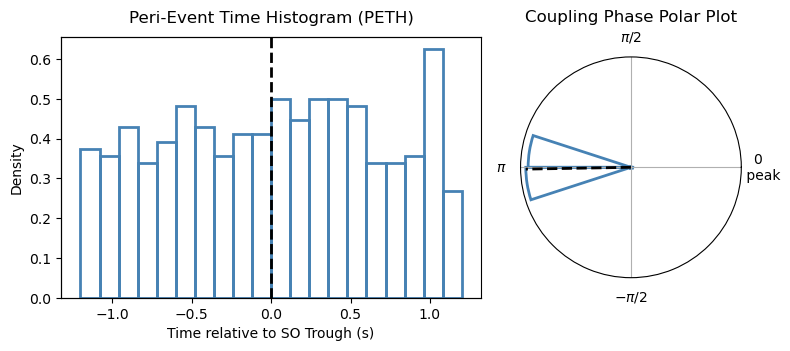

Start event detection for subject ITNS_18_W2_PM2.
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Detected SOs in stage N2
Method: Staresina
PTP amplitude: 142.3213
Mean Duration: 1.3632
SO Density per 30s: 3.3988
Total Count: 571
---------------------------------------------------------------
Detected SOs in stage SWS
Method: Staresina
PTP amplitude: 166.8584
Mean Duration: 1.2428
SO Density per 30s: 3.0000
Total Count: 12
---------------------------------------------------------------
Detected SPs in stage N2
Method: Hahn2020
Average Amplitude: 16.6199 uv
Average Duration: 1.0722s
Spindle Density (per 30s): 3.2381
Total Spindle Count: 544
---------------------------------------------------------------
Detected SPs in stage SWS
Method: Hahn2020
Average Amplitude: 13.6334 uv
Average Duration: 0.6953s
Spindle Density (per 30s): 4.2500
Total Spindle Count: 17
---------------------------------------------------------------
Spindles coupled with SOs in stage

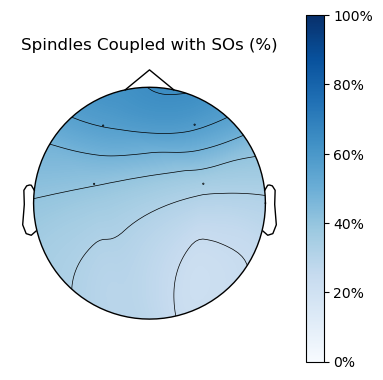

Stage N2:
Preferred Phase:       3.078 rad
Modulation Index:      0.476
Mean Vector Length:    0.034
Rayleigh z:            0.255
p-value:               0.973
Coupling Density:      1.555


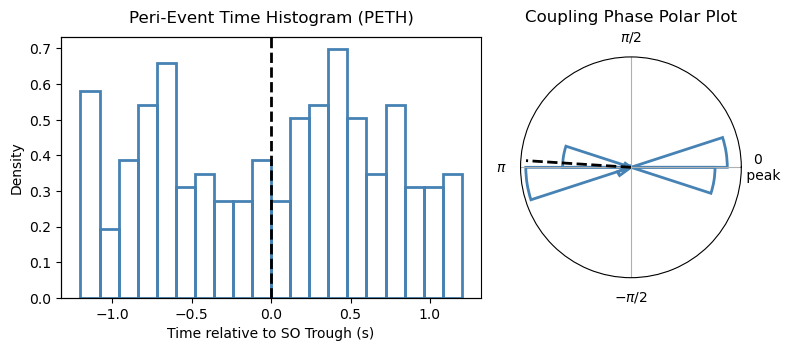

Start event detection for subject ITNS_18_W3_PM1.
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Detected SOs in stage N2
Method: Staresina
PTP amplitude: 151.0568
Mean Duration: 1.4248
SO Density per 30s: 2.9421
Total Count: 1118
---------------------------------------------------------------
Detected SOs in stage SWS
Method: Staresina
PTP amplitude: 230.8692
Mean Duration: 1.3224
SO Density per 30s: 3.6574
Total Count: 790
---------------------------------------------------------------
Detected SPs in stage N2
Method: Hahn2020
Average Amplitude: 15.9236 uv
Average Duration: 0.9483s
Spindle Density (per 30s): 3.7816
Total Spindle Count: 1437
---------------------------------------------------------------
Detected SPs in stage SWS
Method: Hahn2020
Average Amplitude: 16.2961 uv
Average Duration: 1.1855s
Spindle Density (per 30s): 4.0324
Total Spindle Count: 871
---------------------------------------------------------------
Spindles coupled with SOs in s

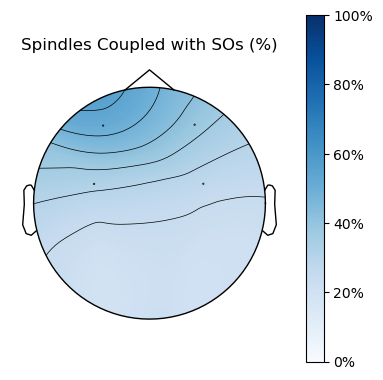

Stage N2:
Preferred Phase:       -0.005 rad
Modulation Index:      0.701
Mean Vector Length:    0.895
Rayleigh z:            338.897
p-value:               0.000
Coupling Density:      1.341
Stage SWS:
Preferred Phase:       0.002 rad
Modulation Index:      0.771
Mean Vector Length:    0.999
Rayleigh z:            268.463
p-value:               0.000
Coupling Density:      1.588


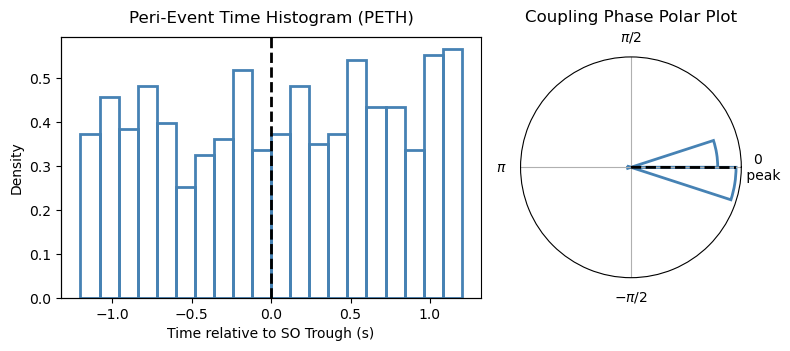

Start event detection for subject ITNS_18_W3_PM2.
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Detected SOs in stage N2
Method: Staresina
PTP amplitude: 174.7112
Mean Duration: 1.4403
SO Density per 30s: 1.7228
Total Count: 696
---------------------------------------------------------------
Detected SPs in stage N2
Method: Hahn2020
Average Amplitude: 12.7588 uv
Average Duration: 0.8561s
Spindle Density (per 30s): 2.8886
Total Spindle Count: 1167
---------------------------------------------------------------
Spindles coupled with SOs in stage N2: 23.99%
SOs coupled with spindles in stage N2: 40.23%
event_summary
    stage channel_x  stage_dur  mean_SO_amp  mean_SO_dur  SO_density channel_y  \
0      2       all   3051.998     0.000175     1.440290    1.722772       all   
1      2       all   3051.998     0.000175     1.440290    1.722772        F3   
2      2       all   3051.998     0.000175     1.440290    1.722772        F4   
3      2       all  

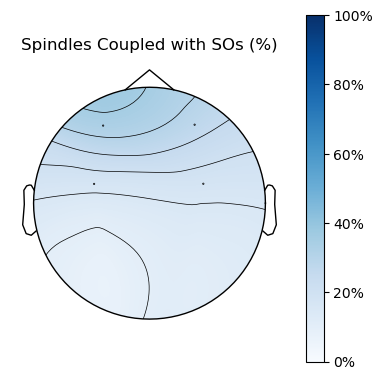

Stage N2:
Preferred Phase:       0.005 rad
Modulation Index:      0.560
Mean Vector Length:    0.361
Rayleigh z:            31.387
p-value:               0.000
Coupling Density:      0.688


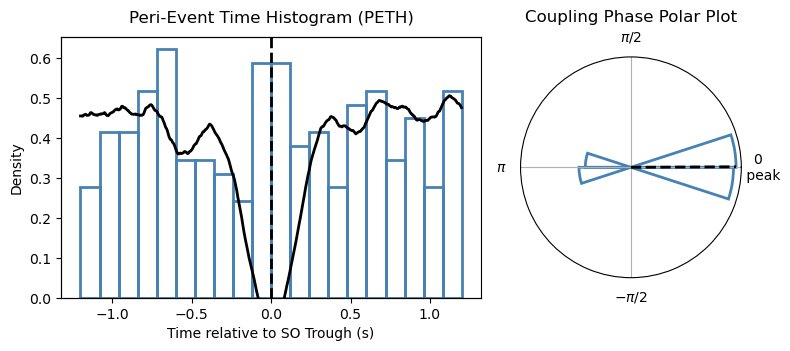

Start event detection for subject ITNS_19_W1_PM1.
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Detected SOs in stage N2
Method: Staresina
PTP amplitude: 150.6381
Mean Duration: 1.4928
SO Density per 30s: 0.9846
Total Count: 319
---------------------------------------------------------------
Detected SPs in stage N2
Method: Hahn2020
Average Amplitude: 20.5612 uv
Average Duration: 1.4743s
Spindle Density (per 30s): 3.8333
Total Spindle Count: 1242
---------------------------------------------------------------
Spindles coupled with SOs in stage N2: 12.00%
SOs coupled with spindles in stage N2: 46.71%
event_summary
    stage channel_x  stage_dur  mean_SO_amp  mean_SO_dur  SO_density channel_y  \
0      2       all       2430     0.000151     1.492765    0.984568       all   
1      2       all       2430     0.000151     1.492765    0.984568        F3   
2      2       all       2430     0.000151     1.492765    0.984568        F4   
3      2       all  

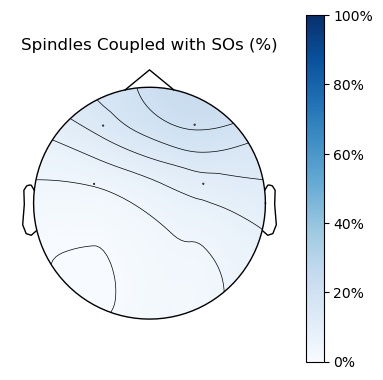

Stage N2:
Preferred Phase:       3.12 rad
Modulation Index:      0.387
Mean Vector Length:    0.214
Rayleigh z:            5.335
p-value:               0.031
Coupling Density:      0.460


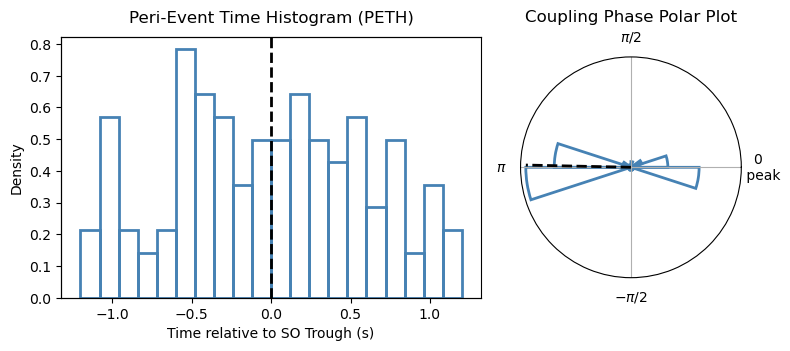

Start event detection for subject ITNS_19_W1_PM2.
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Detected SOs in stage N2
Method: Staresina
PTP amplitude: 145.5860
Mean Duration: 1.4167
SO Density per 30s: 2.0766
Total Count: 922
---------------------------------------------------------------
Detected SPs in stage N2
Method: Hahn2020
Average Amplitude: 23.7750 uv
Average Duration: 1.4954s
Spindle Density (per 30s): 3.9099
Total Spindle Count: 1736
---------------------------------------------------------------
Spindles coupled with SOs in stage N2: 24.14%
SOs coupled with spindles in stage N2: 45.44%
event_summary
    stage channel_x  stage_dur  mean_SO_amp  mean_SO_dur  SO_density channel_y  \
0      2       all       3330     0.000146     1.416670    2.076577       all   
1      2       all       3330     0.000146     1.416670    2.076577        F3   
2      2       all       3330     0.000146     1.416670    2.076577        F4   
3      2       all  

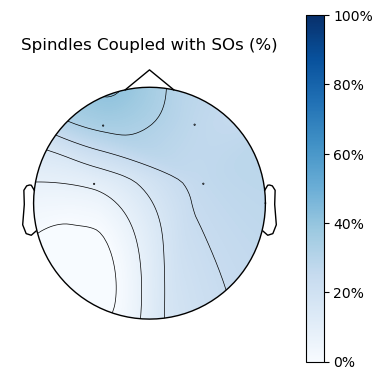

Stage N2:
Preferred Phase:       -3.131 rad
Modulation Index:      0.576
Mean Vector Length:    0.329
Rayleigh z:            36.547
p-value:               0.000
Coupling Density:      0.944


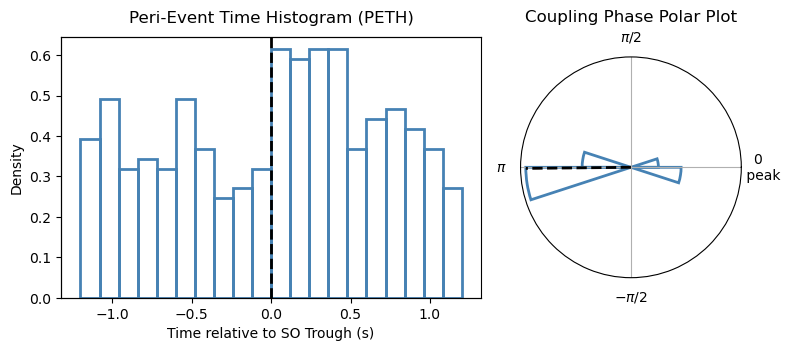

Start event detection for subject ITNS_19_W2_PM1.
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Detected SOs in stage N2
Method: Staresina
PTP amplitude: 142.0638
Mean Duration: 1.3763
SO Density per 30s: 2.2757
Total Count: 974
---------------------------------------------------------------
Detected SOs in stage SWS
Method: Staresina
PTP amplitude: 182.6677
Mean Duration: 1.2698
SO Density per 30s: 3.0000
Total Count: 12
---------------------------------------------------------------
Detected SPs in stage N2
Method: Hahn2020
Average Amplitude: 16.7934 uv
Average Duration: 1.2126s
Spindle Density (per 30s): 3.8551
Total Spindle Count: 1650
---------------------------------------------------------------
Detected SPs in stage SWS
Method: Hahn2020
Average Amplitude: 9.1382 uv
Average Duration: 0.7999s
Spindle Density (per 30s): 3.7500
Total Spindle Count: 15
---------------------------------------------------------------
Spindles coupled with SOs in stage

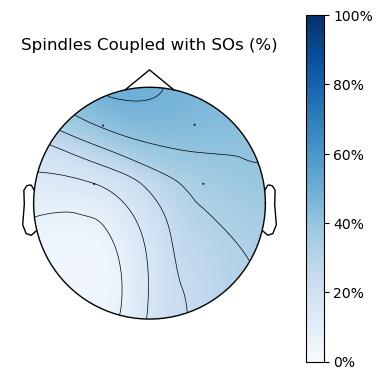

Stage N2:
Preferred Phase:       -3.134 rad
Modulation Index:      0.571
Mean Vector Length:    0.408
Rayleigh z:            74.613
p-value:               0.000
Coupling Density:      1.301
Stage SWS:
Preferred Phase:       -2.987 rad
Modulation Index:      0.788
Mean Vector Length:    0.340
Rayleigh z:            0.347
p-value:               0.952
Coupling Density:      1.000


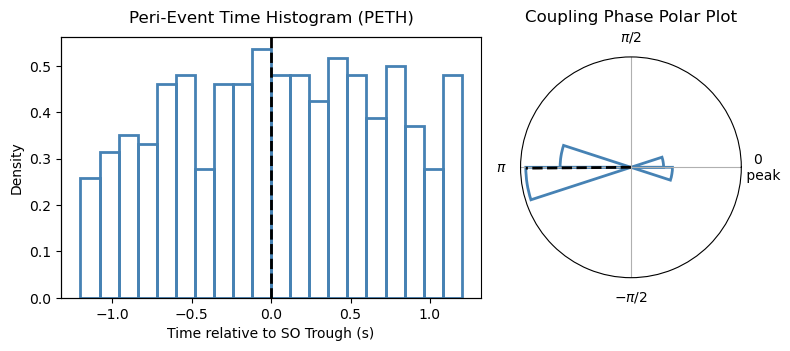

Start event detection for subject ITNS_19_W2_PM2.
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Detected SOs in stage N2
Method: Staresina
PTP amplitude: 240.1253
Mean Duration: 1.3960
SO Density per 30s: 1.8473
Total Count: 1500
---------------------------------------------------------------
Detected SOs in stage SWS
Method: Staresina
PTP amplitude: 144.6362
Mean Duration: 1.2686
SO Density per 30s: 3.2500
Total Count: 13
---------------------------------------------------------------
Detected SPs in stage N2
Method: Hahn2020
Average Amplitude: 32.8069 uv
Average Duration: 1.2767s
Spindle Density (per 30s): 4.0591
Total Spindle Count: 3296
---------------------------------------------------------------
Detected SPs in stage SWS
Method: Hahn2020
Average Amplitude: 16.4963 uv
Average Duration: 1.0248s
Spindle Density (per 30s): 4.7500
Total Spindle Count: 19
---------------------------------------------------------------
Spindles coupled with SOs in sta

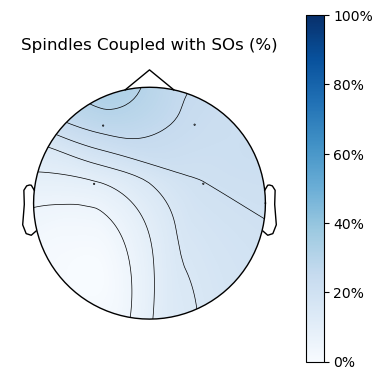

Stage N2:
Preferred Phase:       -3.139 rad
Modulation Index:      0.762
Mean Vector Length:    0.989
Rayleigh z:            517.000
p-value:               0.000
Coupling Density:      0.792
Stage SWS:
Preferred Phase:       -3.14 rad
Modulation Index:      0.772
Mean Vector Length:    1.000
Rayleigh z:            7.000
p-value:               0.007
Coupling Density:      3.667


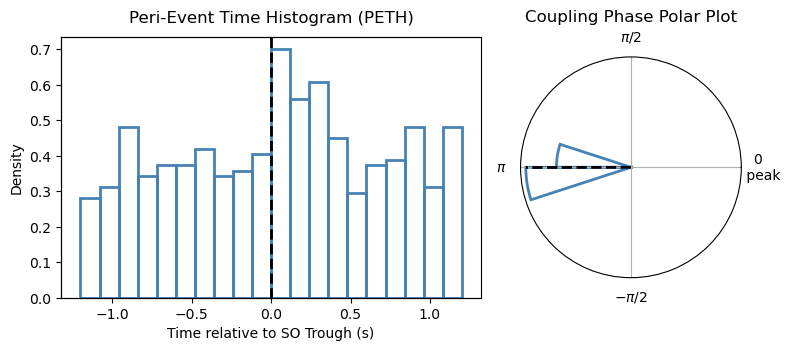

Start event detection for subject ITNS_19_W3_PM1.
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Detected SOs in stage N2
Method: Staresina
PTP amplitude: 149.3835
Mean Duration: 1.4118
SO Density per 30s: 2.1786
Total Count: 1342
---------------------------------------------------------------
Detected SOs in stage SWS
Method: Staresina
PTP amplitude: 239.7623
Mean Duration: 1.3637
SO Density per 30s: 1.3778
Total Count: 248
---------------------------------------------------------------
Detected SPs in stage N2
Method: Hahn2020
Average Amplitude: 17.1112 uv
Average Duration: 1.1202s
Spindle Density (per 30s): 4.2873
Total Spindle Count: 2641
---------------------------------------------------------------
Detected SPs in stage SWS
Method: Hahn2020
Average Amplitude: 18.2091 uv
Average Duration: 1.2044s
Spindle Density (per 30s): 3.9722
Total Spindle Count: 715
---------------------------------------------------------------
Spindles coupled with SOs in s

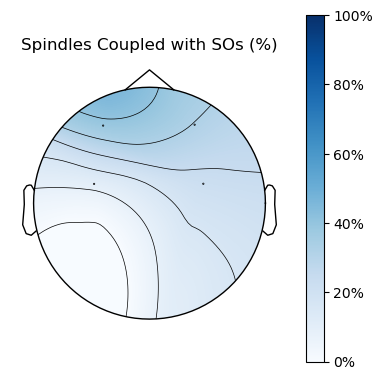

Stage N2:
Preferred Phase:       3.138 rad
Modulation Index:      0.712
Mean Vector Length:    0.926
Rayleigh z:            506.841
p-value:               0.000
Coupling Density:      1.167
Stage SWS:
Preferred Phase:       -3.138 rad
Modulation Index:      0.658
Mean Vector Length:    0.782
Rayleigh z:            61.827
p-value:               0.000
Coupling Density:      0.667


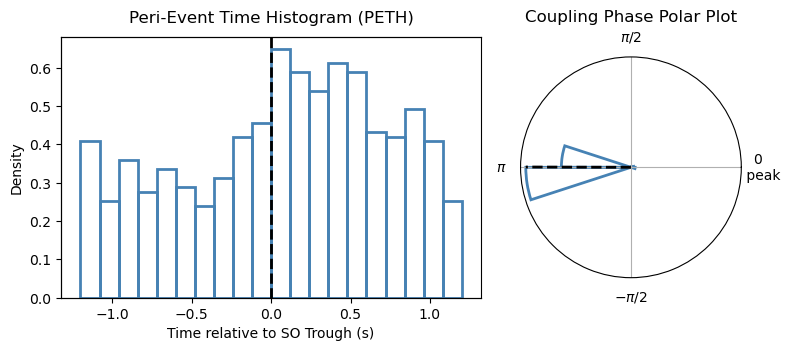

Start event detection for subject ITNS_19_W3_PM2.
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Detected SOs in stage N2
Method: Staresina
PTP amplitude: 176.3772
Mean Duration: 1.3984
SO Density per 30s: 1.5096
Total Count: 314
---------------------------------------------------------------
Detected SOs in stage SWS
Method: Staresina
PTP amplitude: 274.1117
Mean Duration: 1.6098
SO Density per 30s: 0.6786
Total Count: 57
---------------------------------------------------------------
Detected SPs in stage N2
Method: Hahn2020
Average Amplitude: 18.2147 uv
Average Duration: 1.0049s
Spindle Density (per 30s): 4.1058
Total Spindle Count: 854
---------------------------------------------------------------
Detected SPs in stage SWS
Method: Hahn2020
Average Amplitude: 16.1631 uv
Average Duration: 1.0975s
Spindle Density (per 30s): 4.3095
Total Spindle Count: 362
---------------------------------------------------------------
Spindles coupled with SOs in stag

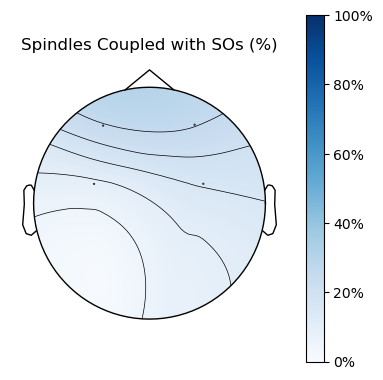

Stage N2:
Preferred Phase:       -3.141 rad
Modulation Index:      0.770
Mean Vector Length:    1.000
Rayleigh z:            151.994
p-value:               0.000
Coupling Density:      0.913
Stage SWS:
Preferred Phase:       -3.14 rad
Modulation Index:      0.769
Mean Vector Length:    1.000
Rayleigh z:            28.997
p-value:               0.000
Coupling Density:      0.429


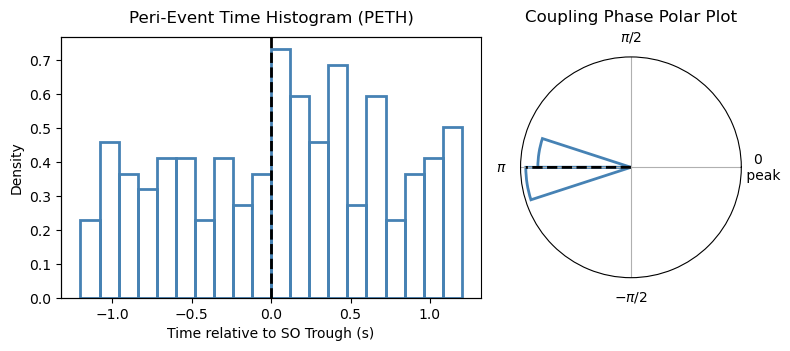

The following participants couldn't be completed:
['ITNS_103_W1_PM2_SD']
Execution time: 9 hours, 5 minutes, 12 seconds


In [7]:



start_time = time.time()

#
# If you have updated any values from the default, you should add them the same way that chan_limit = chan_limit is set here.
#

event_summary_all, coupling_event_all, so_waveform_all=get_sosp_for_folder(processed_eeg_folder, scoring_file, chan_limit = chan_limit, coupling = coupling)

end_time = time.time()

execution_time_seconds = end_time - start_time

hours = int(execution_time_seconds // 3600)
minutes = int((execution_time_seconds % 3600) // 60)
seconds = int(execution_time_seconds % 60)

print(f"Execution time: {hours} hours, {minutes} minutes, {seconds} seconds")

In [8]:
print(event_summary_all)

{'ITNS_102_W1_PM1':    stage channel_x  stage_dur  mean_SO_amp  mean_SO_dur  SO_density channel_y  \
0      2       all       3840     0.000128     1.403697    2.681641       all   
1      2        F3       3840     0.000129     1.391041    3.648438       all   
2      2        F4       3840     0.000127     1.403202    2.781250       all   
3      2        C3       3840     0.000125     1.395038    1.656250       all   
4      2        C4       3840     0.000129     1.427136    2.640625       all   
..   ...       ...        ...          ...          ...         ...       ...   
70   all       all       6390     0.000154     1.382121    2.872066        C4   
71   all        F3       6390     0.000154     1.367188    3.652582        C4   
72   all        F4       6390     0.000153     1.377928    2.854460        C4   
73   all        C3       6390     0.000149     1.375939    1.840376        C4   
74   all        C4       6390     0.000158     1.406921    3.140845        C4   

    mea

In [9]:
print(coupling_event_all)

{'ITNS_102_W1_PM1': None, 'ITNS_102_W2_PM2_SD': None, 'ITNS_102_W3_PM1': None, 'ITNS_102_W3_PM2_SD': None, 'ITNS_103_W1_PM1_SD': None, 'ITNS_103_W2_PM1_SD': None, 'ITNS_103_W2_PM2': None, 'ITNS_103_W3_PM1': None, 'ITNS_103_W3_PM2_SD': None, 'ITNS_112_W1_PM1': None, 'ITNS_112_W1_PM2_SD': None, 'ITNS_112_W2_PM1': None, 'ITNS_112_W2_PM2': None, 'ITNS_112_W3_PM1': None, 'ITNS_112_W3_PM2': None, 'ITNS_113_W1_PM1': None, 'ITNS_113_W1_PM2': None, 'ITNS_113_W2_PM1': None, 'ITNS_113_W2_PM2_SD': None, 'ITNS_113_W3_PM2_SD': None, 'ITNS_119_W1_PM1_SD': None, 'ITNS_119_W1_PM2_SD': None, 'ITNS_119_W2_PM1_SD': None, 'ITNS_119_W2_PM2_SD': None, 'ITNS_119_W3_PM1_SD': None, 'ITNS_119_W3_PM2_SD': None, 'ITNS_122_W1_PM1_SD': None, 'ITNS_122_W1_PM2': None, 'ITNS_122_W2_PM1_SD': None, 'ITNS_122_W2_PM2_a_SD': None, 'ITNS_122_W2_PM2_b_SD': None, 'ITNS_122_W3_PM1_SD': None, 'ITNS_122_W3_PM2': None, 'ITNS_18_W1_PM1': None, 'ITNS_18_W1_PM2': None, 'ITNS_18_W2_PM1': None, 'ITNS_18_W2_PM2': None, 'ITNS_18_W3_PM1':

In [10]:
print(so_waveform_all)

{'ITNS_102_W1_PM1':   stage                                        so_waveform
0   all  -5055.034905715587,-5054.910206355037,-5054.86...
1     2  -5275.563933715432,-5275.40354046401,-5275.390...
2     3  -4791.173858178944,-4791.091866245708,-4791.01..., 'ITNS_102_W2_PM2_SD':   stage                                        so_waveform
0   all  78480.23592048895,78429.25844251616,78270.2678...
1     2  114107.38646541451,114107.09322876396,113915.6...
2     3  17851.57622122965,17714.34661328744,17610.5511..., 'ITNS_102_W3_PM1':   stage                                        so_waveform
0   all  -2139.1176815661674,-2139.0832775969834,-2139....
1     2  -2208.1337657341896,-2208.1616334218274,-2208....
2     3  -2044.5751005140849,-2044.4553929054227,-2044...., 'ITNS_102_W3_PM2_SD':   stage                                        so_waveform
0   all  -8725.181328771729,-8725.033877465716,-8725.09...
1     2  -8590.50410673035,-8590.55056437558,-8590.7686...
2     3  -8847.882573190087,-